# Lamina Monopolar Cell Connectivity Patterns
Exploratory data analysis: what variables seperate the different classes of LMCs we identified?

In [1]:
import numpy as np
import pandas as pd
from typing import Tuple, Union, List
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.decomposition import PCA
import itertools

from cx_analysis.vis.fig_tools import subtype_cm



In [2]:
### Plot style ###
c = subtype_cm()
plt.rcdefaults()
plt.style.use('../cx_analysis/vis/lamina.mplstyle')
### SAVE FIGS? ###
save_figs = False
fig_path = 'figures/'

In [3]:
tp = '210809'
linkdf = pd.read_pickle('Data/210809_linkdf.pickle')
cxdf = pd.read_pickle('Data/210809_cxdf.pickle')

#display(cxdf)

subtypes = np.unique([*linkdf["pre_type"], *linkdf["post_type"]])
lmcs = [s for s in subtypes if s[0] == 'L']

all_ctypes = [p for p in itertools.product(subtypes, subtypes)]  
all_ctype_labels = [f"{pre}->{post}" for pre, post in all_ctypes]
ommatidia = np.unique(linkdf['pre_om'])

# df of interommatidial connections
criteria = ((linkdf['pre_om'] != linkdf['post_om']) & (linkdf['post_om'] != 'UNKNOWN'))
interdf = linkdf.loc[criteria]

om_with_no_l4 = ['B0', 'C1', 'D2', 'E4', 'E5', 'E6', 'E7']

,om,cx_type,pre_type,post_type,n_connect
0,A0,LMC_1->LMC_1,LMC_1,LMC_1,0.0
1,A0,LMC_1->LMC_2,LMC_1,LMC_2,0.0
2,A0,LMC_1->LMC_3,LMC_1,LMC_3,0.0
3,A0,LMC_1->LMC_4,LMC_1,LMC_4,0.0
4,A0,LMC_1->LMC_N,LMC_1,LMC_N,0.0
...,...,...,...,...,...
3504,E7,centri->R_quartet,centri,R_quartet,3.0
3505,E7,centri->R7,centri,R7,14.0
3506,E7,centri->R7p,centri,R7p,18.0
3507,E7,centri->R8,centri,R8,8.0


In [4]:
subtypes

array(['LMC_1', 'LMC_2', 'LMC_3', 'LMC_4', 'LMC_N', 'R7', 'R7p', 'R8',
       'R_duet', 'R_quartet', 'UNKNOWN', 'centri'], dtype='<U9')

In [5]:
### Assemble df of LMC outputs ###
out_counts = []
for om, r in cxdf.groupby('om'):
    for pre, rr in r.groupby('pre_type'):
        if (om in om_with_no_l4) and (pre == 'LMC_4'):
            continue
        else:
            out_counts.append({'om': om, 
                               'type': pre, 
                               'output_count': rr['n_connect'].sum()})
# data contains cols for number of overall outputs and number of inputs from each subtype
data = pd.DataFrame(out_counts)
for s in subtypes:
    data[s] = np.zeros(len(data.index))
    
inter_in = np.zeros(len(data.index), dtype=int)
for i, row in data.iterrows():
    # Home inputs
    criteria = (cxdf['om'] == row['om']) & (cxdf['post_type'] == row['type'])
    inputs = cxdf.loc[criteria, ('pre_type', 'n_connect')].set_index('pre_type').to_dict()
    data.iloc[i, 3:-1] = pd.Series(inputs['n_connect'])
    # Inputs to the lmcs from outside home
    criteria = ((interdf['post_om'] == row['om']) & (interdf['post_type'] == row['type']))
    inter_in[i] = len(interdf.loc[criteria])
        
data['inter_in'] = inter_in
#display(data.loc[data["type"] == 'LMC_4'])


In [6]:
linkdf

,link_id,cx_id,pre_neuron,pre_om,pre_type,pre_skel,post_neuron,post_om,post_type,post_skel
0,194220,276258,omB6_LN,B6,LMC_N,25,omB6_L1,B6,LMC_1,175606
1,175596,276258,omB6_LN,B6,LMC_N,25,omB6_L2,B6,LMC_2,44725
2,175139,276258,omB6_LN,B6,LMC_N,25,omB6_L1,B6,LMC_1,175606
3,175128,276258,omB6_LN,B6,LMC_N,25,omB6_R3,B6,R_quartet,174970
4,175628,277482,omB6_LN,B6,LMC_N,25,168408,UNKNOWN,UNKNOWN,168408
...,...,...,...,...,...,...,...,...,...,...
20774,318465,479967,omC2_centri_nc,C2,centri,319210,omC2_centri_nc,C2,centri,319210
20775,318468,479967,omC2_centri_nc,C2,centri,319210,omC2_R4_nc,C2,R_quartet,294885
20776,318467,479967,omC2_centri_nc,C2,centri,319210,omC2_L3_nc,C2,LMC_3,309836
20777,318466,479967,omC2_centri_nc,C2,centri,319210,omC2_R7p_nc,C2,R7p,294545


36

53

35

27

0

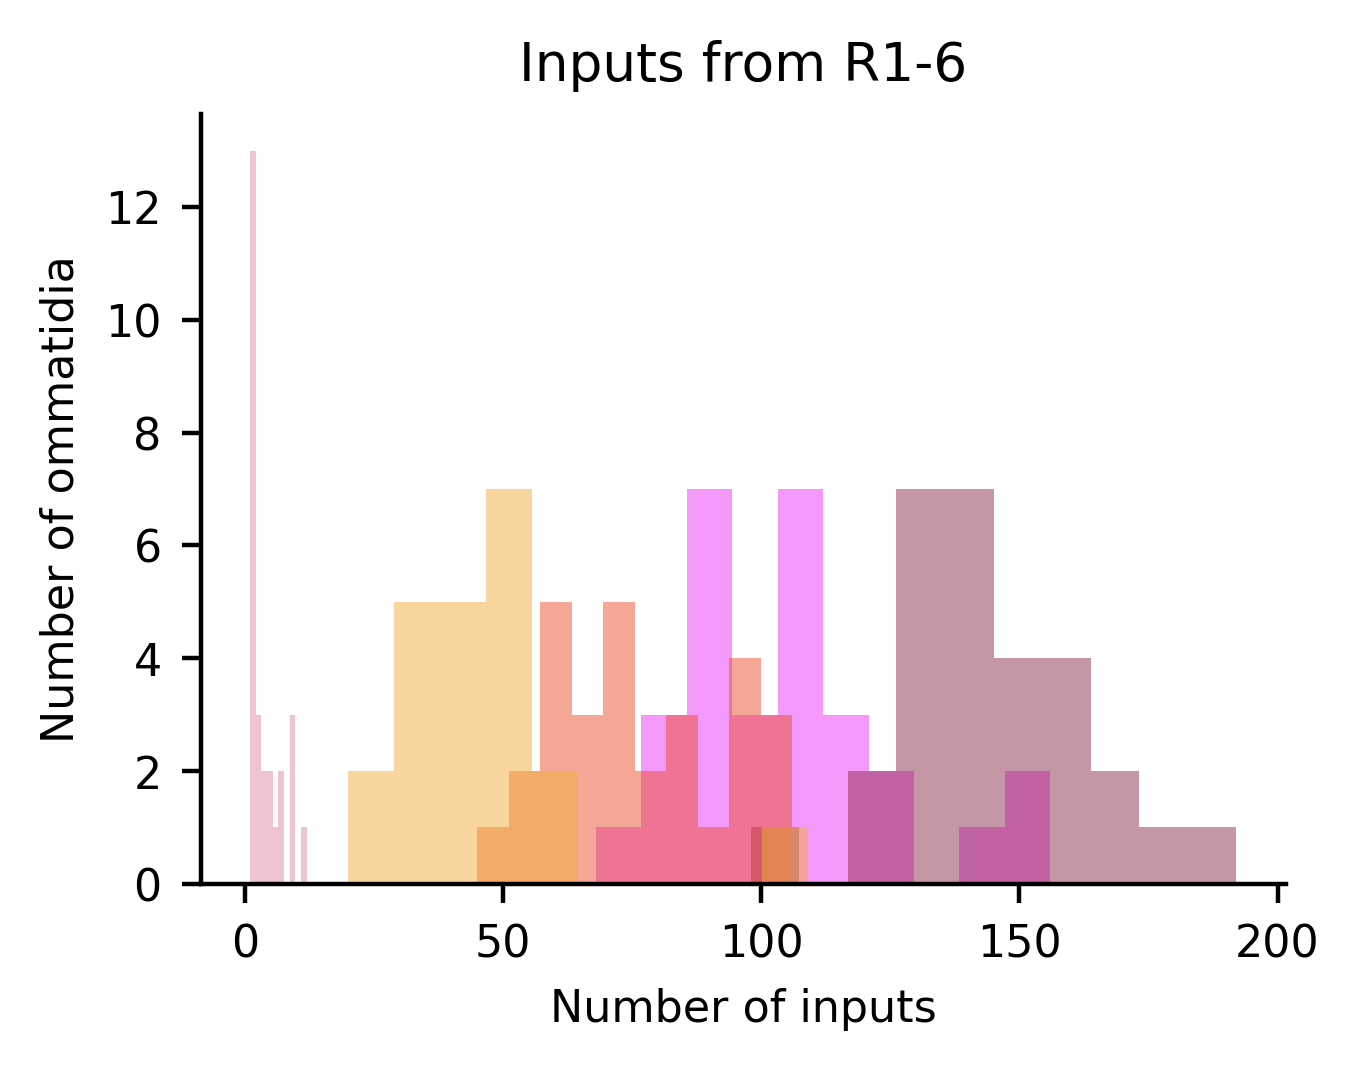

In [7]:
fig, ax = plt.subplots(1, figsize=[3.5, 2.5])

# ax.set_xlabel('Inputs from R1-6')
# ax.set_ylabel('Ommatidia')

for post, rows in linkdf.groupby('post_type'):
    
    if 'LMC' not in post:
        continue
    else:
        svf_inputs = []
        duet_bias = []
        quartet_bias = []
        om_list = []
        for om, rr in rows.groupby('post_om'):
            om_list.append(om)
            q_count = rr.value_counts('pre_type').get('R_duet', default=0)
            d_count = rr.value_counts('pre_type').get('R_quartet', default=0)
            svf_inputs.append(q_count + d_count)
            if d_count == 0 or q_count == 0:
                duet_bias.append(np.nan)
                quartet_bias.append(np.nan)
            else:
                duet_bias.append(d_count/q_count)
                quartet_bias.append(q_count/d_count)
        
        display(q_count)
        ax.hist(svf_inputs, label=post, color=c[post], alpha=0.5)
#         ax[1].hist(duet_bias, label=post, color=c[post], alpha=0.5)
#         ax[2].hist(quartet_bias, label=post, color=c[post], alpha=0.5)
ax.set_title('Inputs from R1-6')
ax.set_xlabel('Number of inputs')
ax.set_ylabel('Number of ommatidia')
if save_figs:
    fig.savefig(fig_path + 'LMC_pr_inputs.svg')
    fig.savefig(fig_path + 'LMC_pr_inputs.png')

51

34

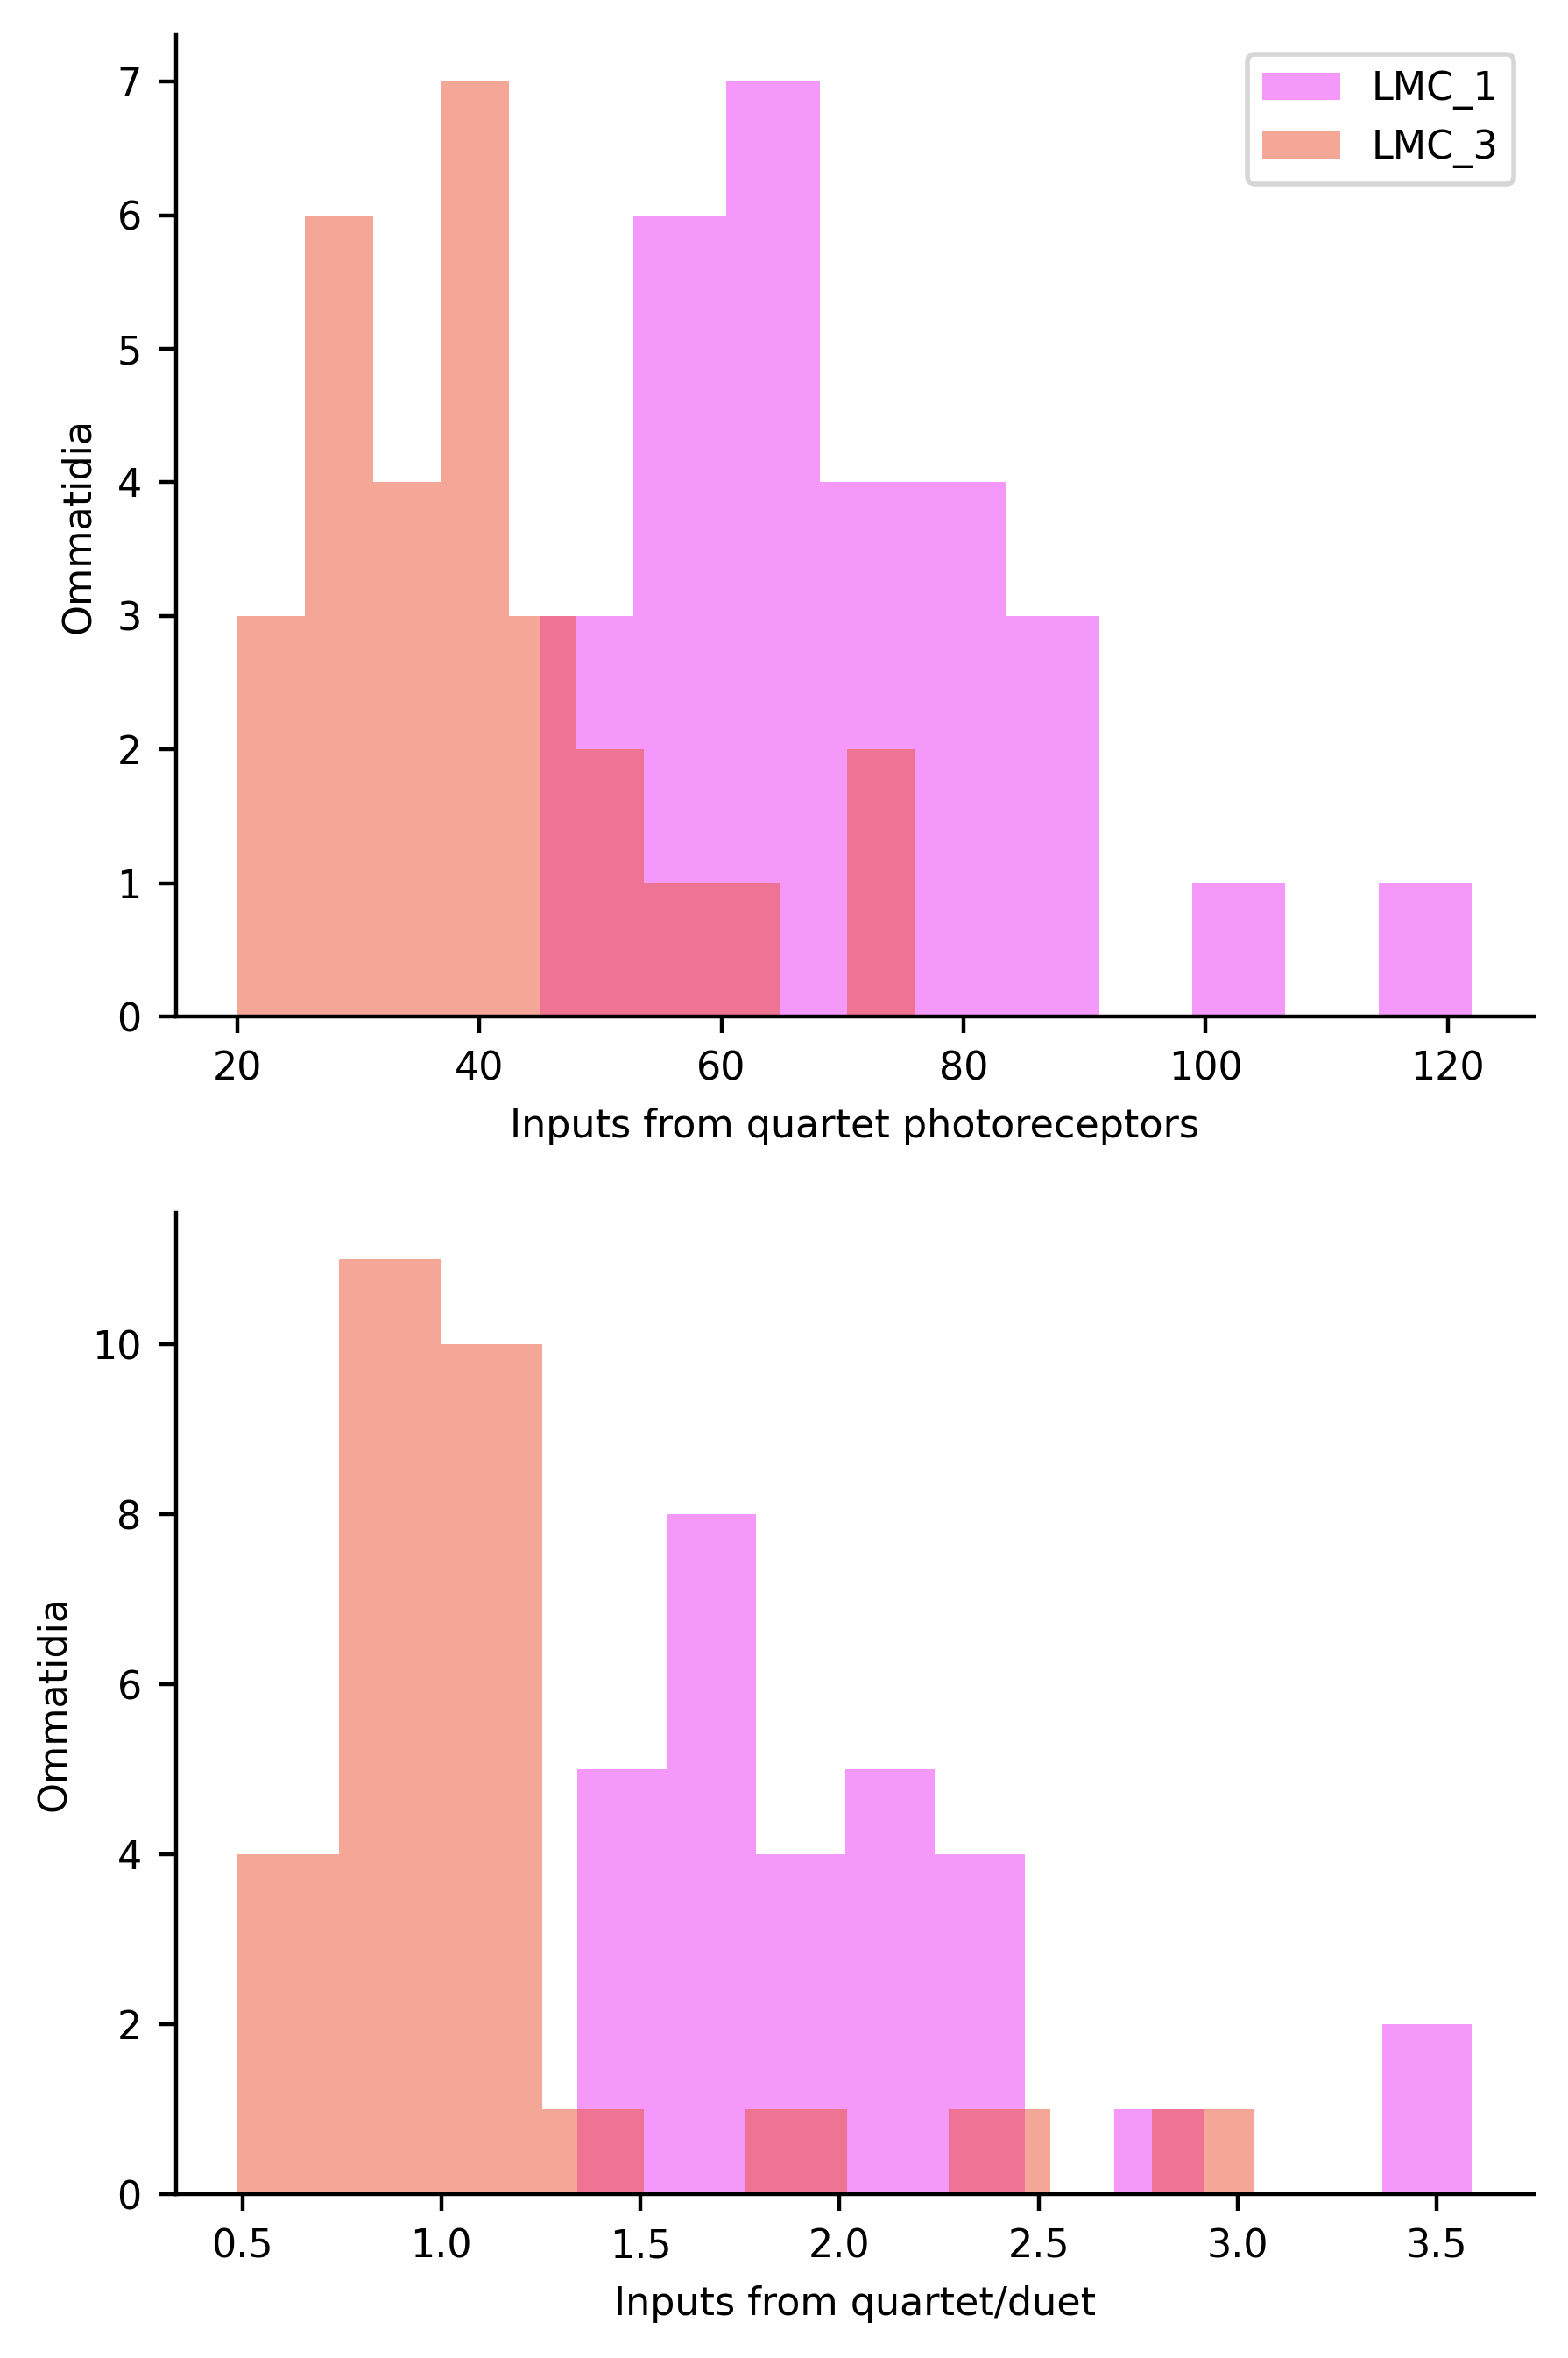

In [39]:
fig, ax = plt.subplots(2, 1, figsize=[5, 8])

# ax.set_xlabel('Inputs from R1-6')
# ax.set_ylabel('Ommatidia')

for post, rows in linkdf.groupby('post_type'):
    
    if post not in ['LMC_1', 'LMC_3']:
        continue
    else:
        svf_inputs = []
        duet_bias = []
        quartet_bias = []
        q_counts = []
        om_list = []
        for om, rr in rows.groupby('post_om'):
            om_list.append(om)
            q_count = rr.value_counts('pre_type').get('R_quartet', default=0)
            q_counts.append(q_count)
            d_count = rr.value_counts('pre_type').get('R_duet', default=0)
            svf_inputs.append(q_count + d_count)
            if d_count == 0 or q_count == 0:
                duet_bias.append(np.nan)
                quartet_bias.append(np.nan)
            else:
                duet_bias.append(d_count/q_count)
                quartet_bias.append(q_count/d_count)
        
        display(q_count)

        ax[0].hist(q_counts, label=post, color=c[post], alpha=0.5)
        ax[1].hist(quartet_bias, label=post, color=c[post], alpha=0.5)
ax[0].set_xlabel('Inputs from quartet photoreceptors')
ax[1].set_xlabel('Inputs from quartet/duet')

ax[0].set_ylabel('Ommatidia')
ax[1].set_ylabel('Ommatidia')
ax[0].legend()
# for post in lmcs:
#     r1to6 = link_df.pre_type == 'R_quartet' or link_df.pre_type == 'R_duet'
    
#     cx = len(linkdf.loc[criteria])
#     x = cx.sum(axis=1)
#     #sns.distplot(x, ax=ax, color=c[post], label=post[0] + post[-1], kde=False)
#     ax.hist(x, color=c[post], label=post, alpha=0.7)
#     print(f"{post}, max = {x.max()}, min = {x.min()}")
#ax.legend()

if save_figs:
    fig.savefig(fig_path + 'LMC_pr_inputs.svg')
    fig.savefig(fig_path + 'LMC_pr_inputs.png')

/tmp/ipykernel_991654/2577059718.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


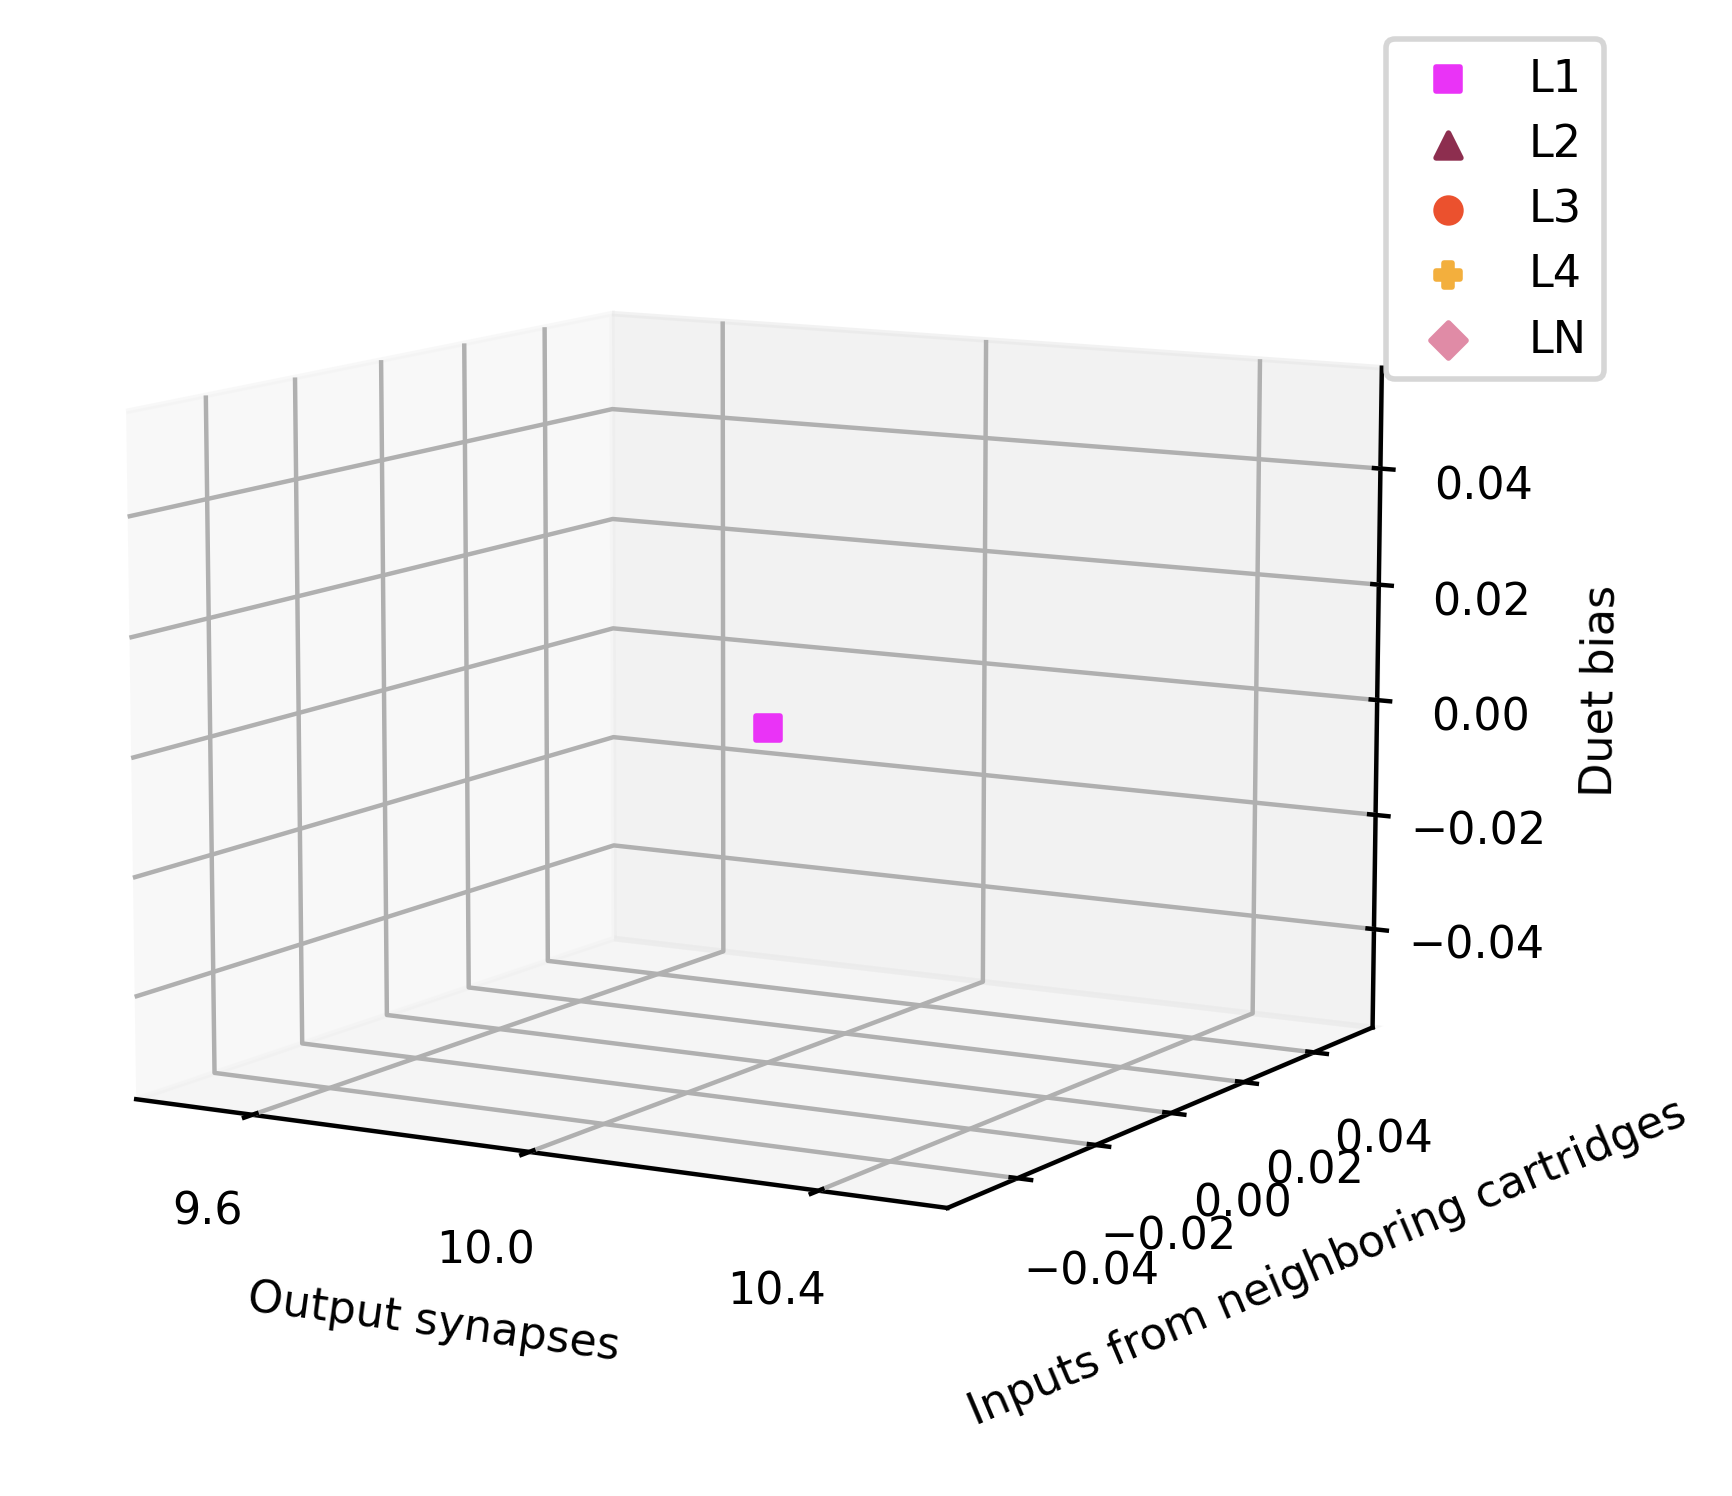

In [14]:
fig = plt.figure(figsize=[4.6, 4.6])
ax = fig.gca(projection='3d')
ax.set_xlabel('Output synapses')
ax.set_zlabel('Duet bias')
ax.set_ylabel('Inputs from neighboring cartridges')

c = subtype_cm()

m = {'LMC_N': 'D', 'LMC_1': 's', 'LMC_2': '^', 'LMC_3': 'o', 'LMC_4': 'P'}

for pre, rows in data.groupby('type'):
    if pre not in lmcs:
        continue
    else:
        
        infrac = rows['R_duet']/rows['R_quartet']
        ax.scatter(rows['output_count'], rows['inter_in'], infrac, 
                   label=f"L{pre.split('_')[1]}", marker=m[pre],
                   c=c[pre], depthshade=True)
        #ax.scatter(rows['R1R4'] + rows['R3R6'], rows['inter_in'], rows['output_count'], label=pre)
plt.legend(bbox_to_anchor=(0.95, 1), loc='upper left', borderaxespad=0.)
# maxx = max(data['R1R4'] + data['R3R6'])
# maxy = max(data['inter_in'])

# ax.set_xlim([0, maxx + maxx % 5])
# ax.set_ylim([0, maxy + maxy % 5])
# ax.set_zlim()
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
#ax.invert_yaxis()
ax.view_init(elev=10)

plt.show()

if save_figs:
    fig.savefig(fig_path + 'LMC_properties_3D.svg')
    fig.savefig(fig_path + 'LMC_properties_3D.png')

<ipython-input-55-8ea516ae2e69>:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


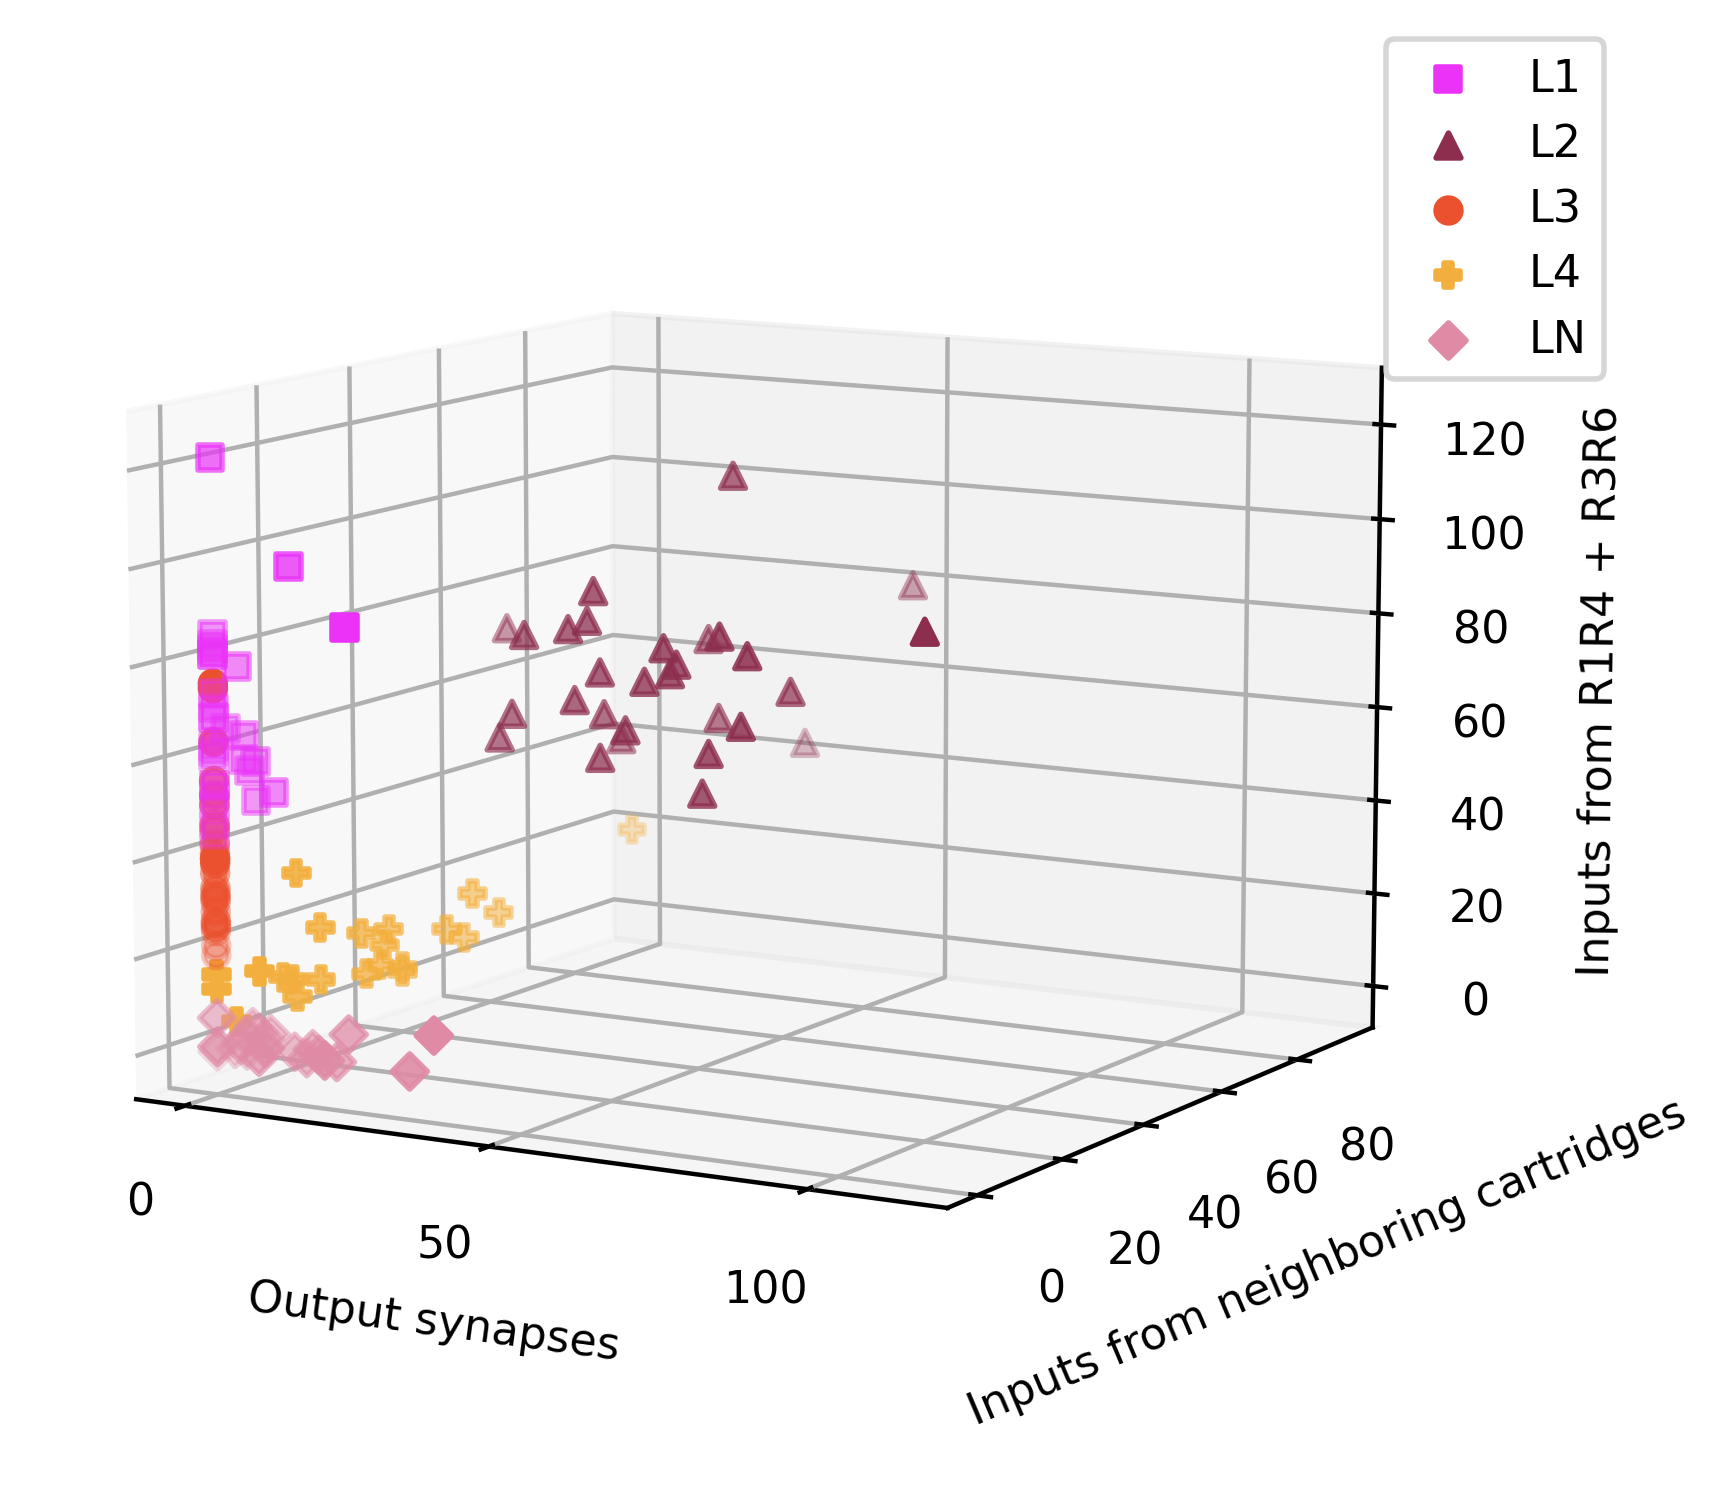

In [55]:
fig = plt.figure(figsize=[4.6, 4.6])
ax = fig.gca(projection='3d')
ax.set_xlabel('Output synapses')
ax.set_zlabel('Inputs from R1R4 + R3R6')
ax.set_ylabel('Inputs from neighboring cartridges')

c = subtype_cm()

m = {'LMC_N': 'D', 'LMC_1': 's', 'LMC_2': '^', 'LMC_3': 'o', 'LMC_4': 'P'}

for pre, rows in data.groupby('type'):
    if pre not in lmcs:
        continue
    else:
        
        infrac = rows['R1R4'] + rows['R3R6']
        ax.scatter(rows['output_count'], rows['inter_in'], infrac, 
                   label=f"L{pre.split('_')[1]}", marker=m[pre],
                   c=c[pre], depthshade=True)
        #ax.scatter(rows['R1R4'] + rows['R3R6'], rows['inter_in'], rows['output_count'], label=pre)
plt.legend(bbox_to_anchor=(0.95, 1), loc='upper left', borderaxespad=0.)
# maxx = max(data['R1R4'] + data['R3R6'])
# maxy = max(data['inter_in'])

# ax.set_xlim([0, maxx + maxx % 5])
# ax.set_ylim([0, maxy + maxy % 5])
# ax.set_zlim()
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
#ax.invert_yaxis()
ax.view_init(elev=10)

plt.show()

if save_figs:
    fig.savefig(fig_path + 'LMC_properties_3D.svg')
    fig.savefig(fig_path + 'LMC_properties_3D.png')

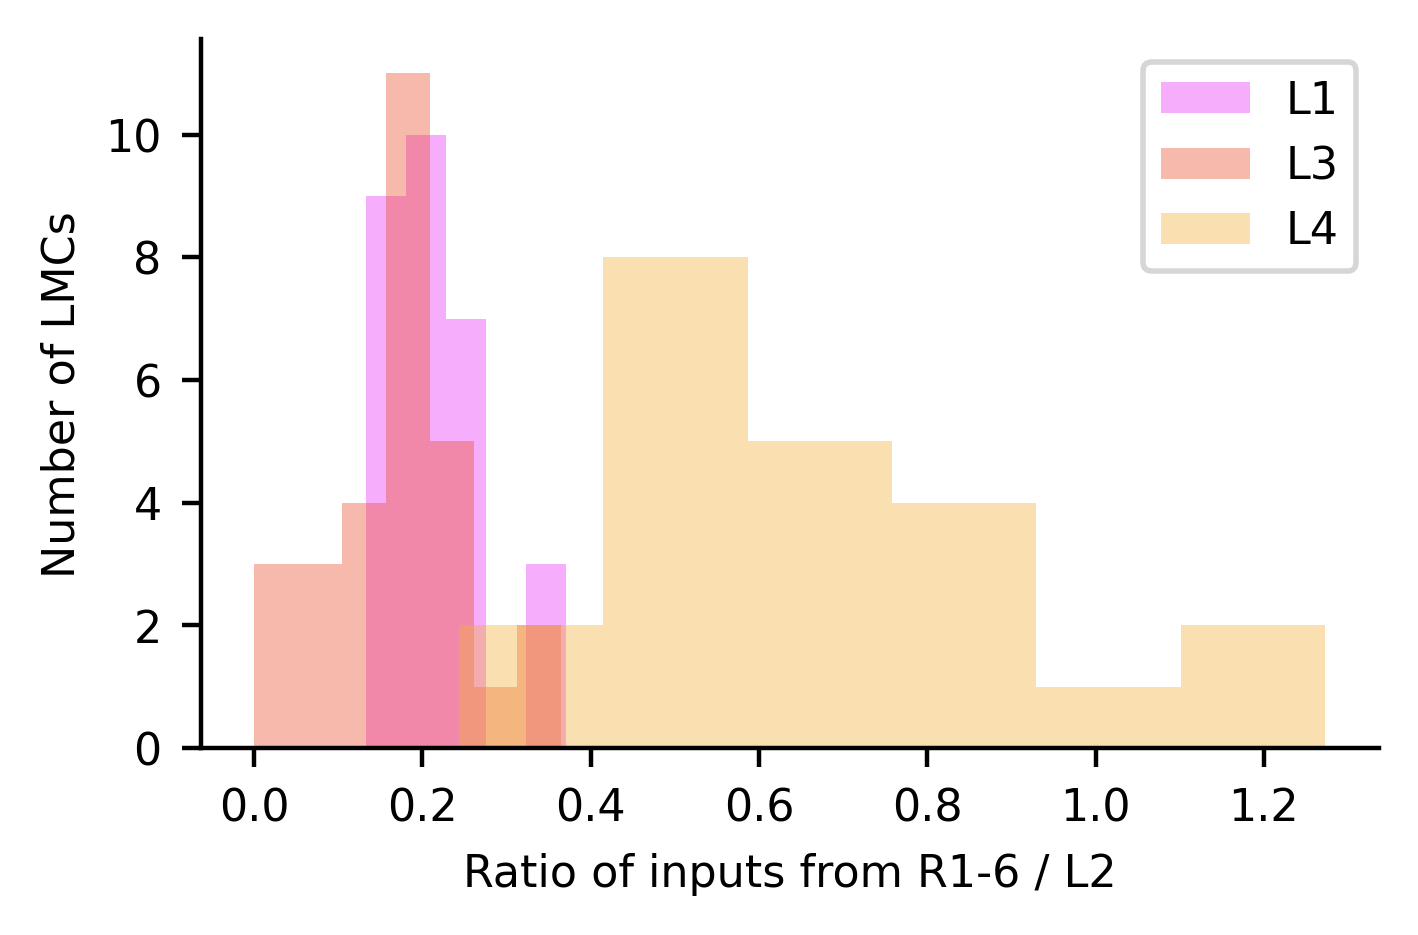

In [61]:
fig, ax = plt.subplots(1)

ax.set_xlabel('Ratio of inputs from R1-6 / L2')
ax.set_ylabel('Number of LMCs')

def div0(num, denom):
    results = []
    for n, d in zip(num, denom):
        if d == 0:
            results.append(np.nan)
        else:
            results.append(float(n)/float(d))
    return results

for post in lmcs:
    if post in ['LMC_2', 'LMC_N']:
        continue
    pr_in = data.loc[data['type'] == post, ('R2R5', 'R1R4', 'R3R6')].sum(axis=1)
    l2_in = data.loc[data['type'] == post, 'LMC_2']
    #x = pr_in - l2_in
    x = div0(l2_in, pr_in)
    sns.distplot(x, ax=ax, color=c[post], label=post[0] + post[-1], kde=False)
    #print(f"{post}, max = {x.max()}, min = {x.min()}")
ax.legend()



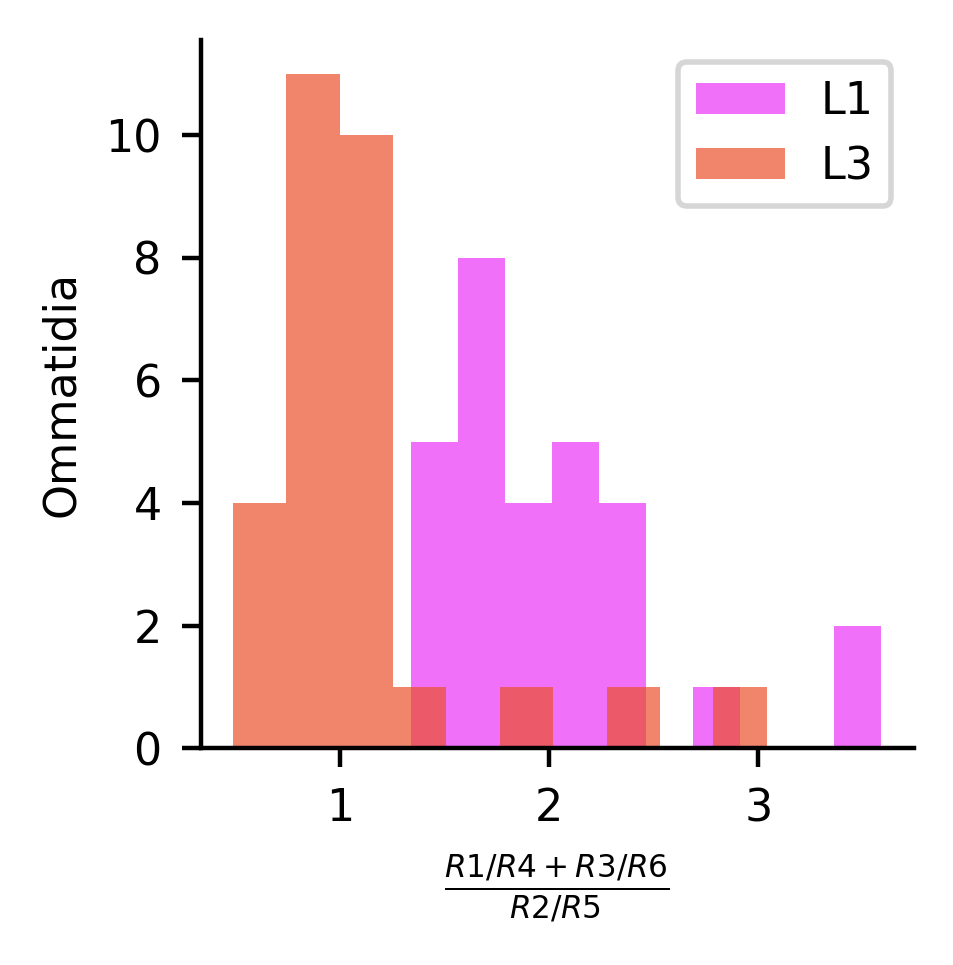

In [70]:
fig, ax = plt.subplots(1, figsize=[2.3, 2.3])

ax.set_xlabel(r'$\frac{R1/R4 + R3/R6}{R2/R5}$')
ax.set_ylabel('Ommatidia')

def div0(num, denom):
    results = []
    for n, d in zip(num, denom):
        if d == 0:
            results.append(np.nan)
        else:
            results.append(float(n)/float(d))
    return results

for post in lmcs:
    if post not in ['LMC_1', 'LMC_3']:
        continue
    else:
        quartet = data.loc[data['type'] == post, ('R1R4', 'R3R6')].sum(axis=1)
        duo = data.loc[data['type'] == post, 'R2R5']
    
        x = div0(quartet, duo)
        ax.hist(x, color=c[post], label=post[0] + post[-1], alpha=0.7)
    #print(f"{post}, max = {x.max()}, min = {x.min()}")
ax.legend()

if save_figs:
    fig.savefig(fig_path + 'L1L3_pr_bias.svg')
    fig.savefig(fig_path + 'L1L3_pr_bias.png')

## LN receives significantly fewer R1-6 inputs than the anucleate LMC subtypes

In [10]:
nuc = data.loc[data['type'] == 'LMC_N', ('R2R5', 'R1R4', 'R3R6')].sum(axis=1)

anuc = data.loc[data['type'].isin(['LMC_1', 'LMC_2', 'LMC_3', 'LMC_4']), 
                ('R2R5', 'R1R4', 'R3R6')].sum(axis=1)

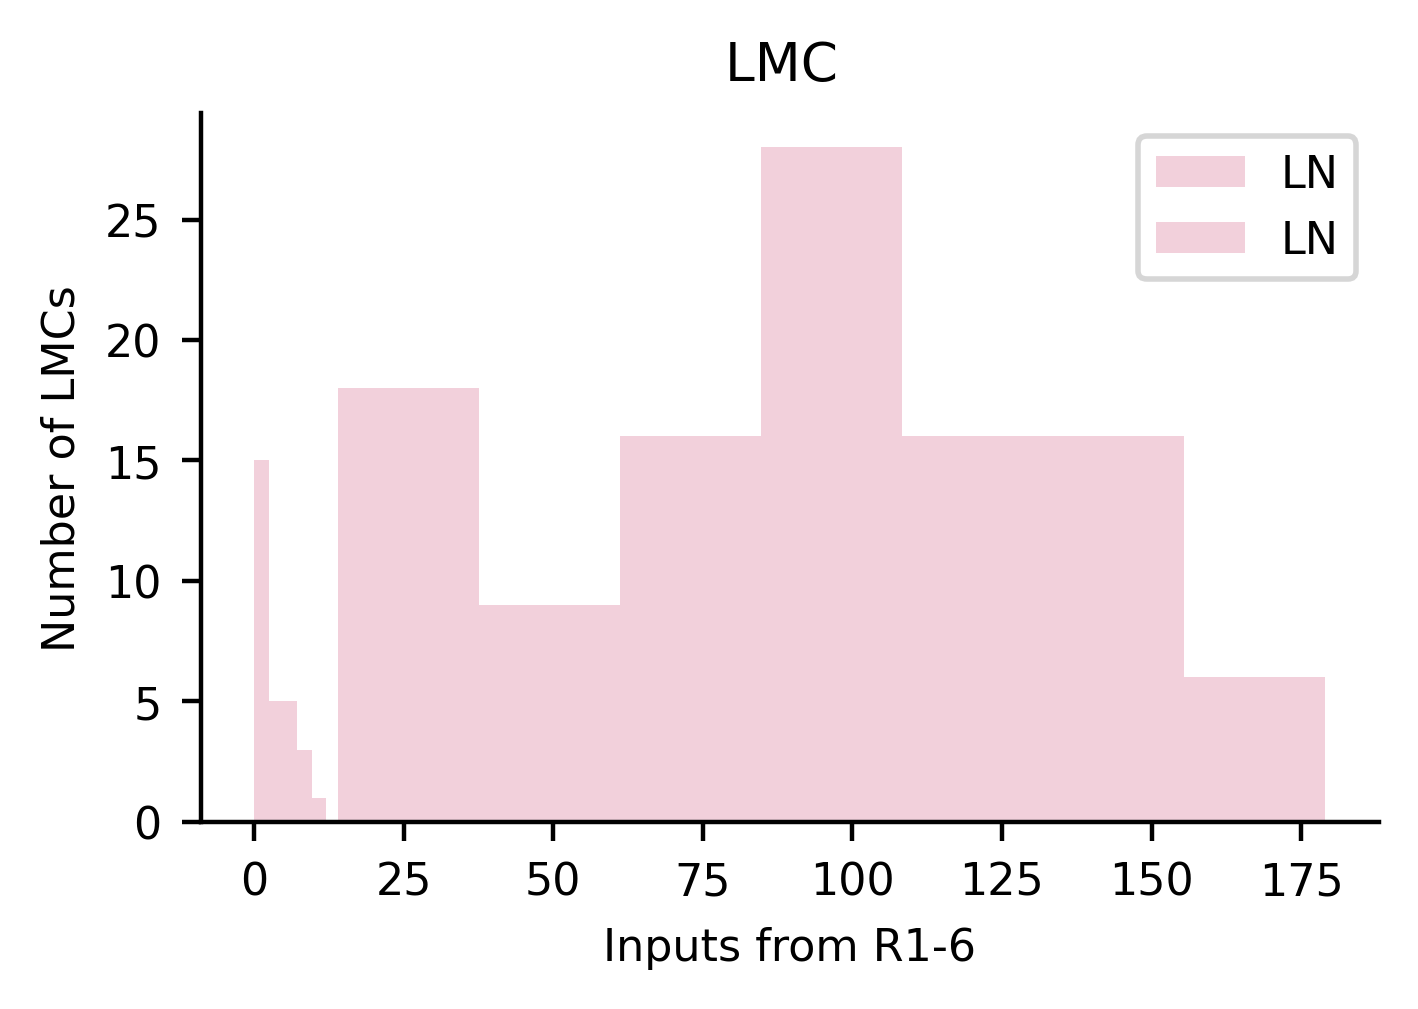

In [11]:
fig, ax = plt.subplots(1)

ax.set_xlabel('Inputs from R1-6')
ax.set_ylabel('Number of LMCs')

x = data.loc[data['type'] == 'LMC_N', ('R2R5', 'R1R4', 'R3R6')].sum(axis=1)
sns.distplot(x, ax=ax, color=c['LMC_N'], label='LN', kde=False)

anucleate = data.loc[data['type'].isin(['LMC_1', 'LMC_2', 'LMC_3', 'LMC_4'])]
x = anucleate.loc[:, ('R2R5', 'R1R4', 'R3R6')].sum(axis=1)
sns.distplot(x, ax=ax, color=c[post], label=post[0] + post[-1], kde=False)
ax.legend()

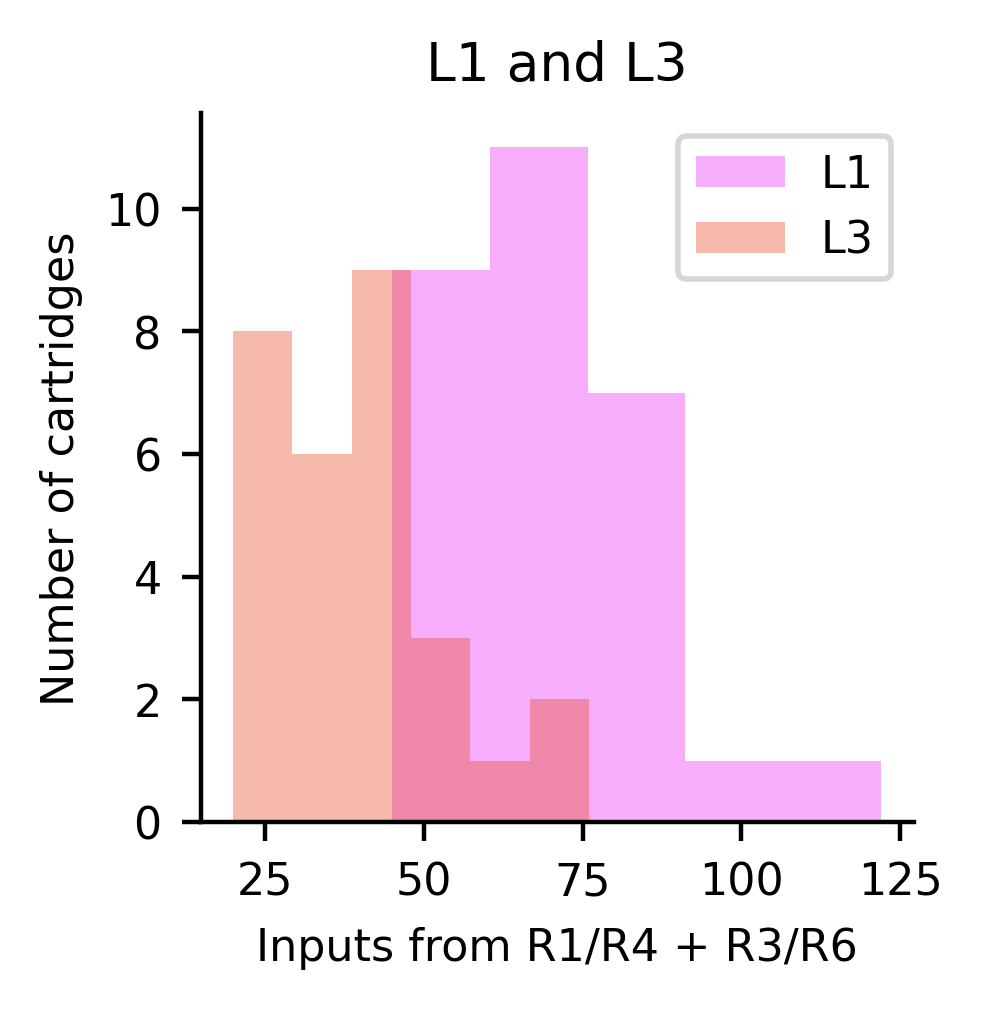

In [14]:
fig, ax = plt.subplots(1, figsize=[2.3, 2.3])
ax.set_title('L1 and L3')
ax.set_xlabel('Inputs from R1/R4 + R3/R6')
ax.set_ylabel('Number of cartridges')
for post in ['LMC_1', 'LMC_3']:
    
    x = data.loc[data['type'] == post, ('R1R4', 'R3R6')].sum(axis=1)
    sns.distplot(x, ax=ax, color=c[post], kde=False,
                hist_kws={'label': post[0] + post[-1]})
ax.legend()

LMC_1 min = 1.3414634146341464, max = 3.588235294117647
LMC_3 min = 0.4878048780487805, max = 3.04


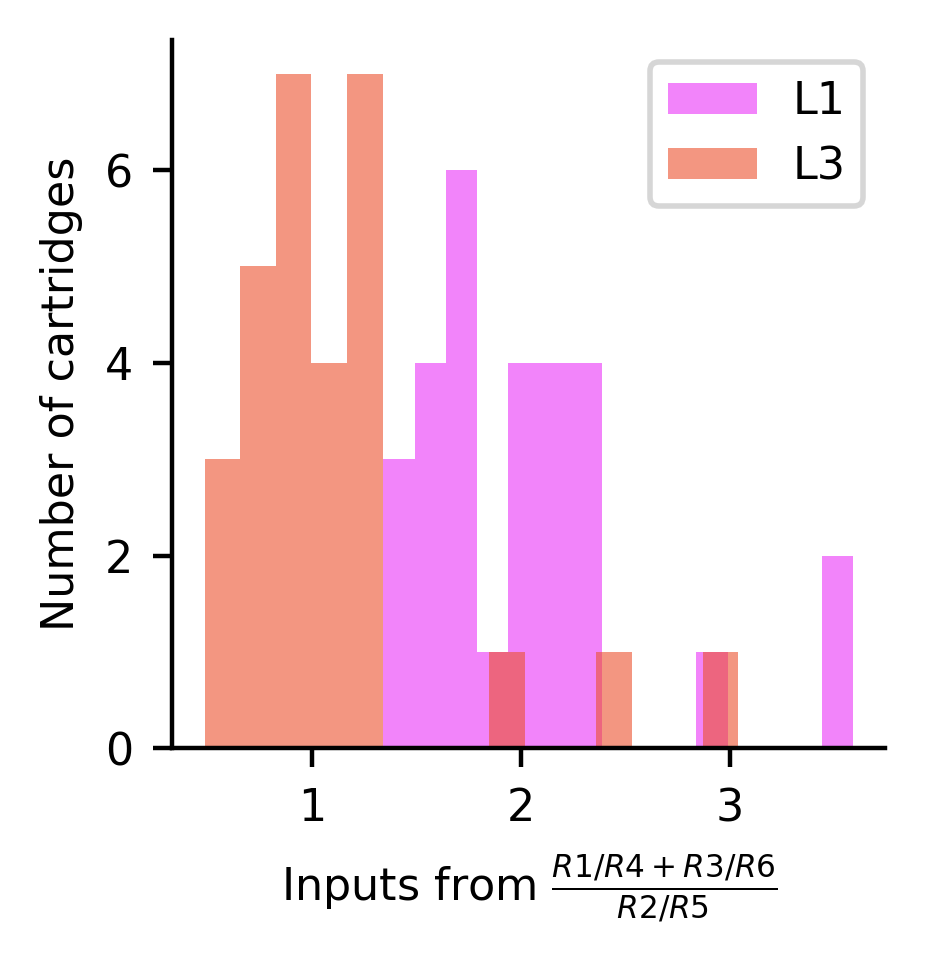

In [40]:
fig, ax = plt.subplots(1, figsize=[2.3, 2.3])
#ax.set_title('L1 and L3')
ax.set_xlabel(r'Inputs from $\frac{R1/R4 + R3/R6}{R2/R5}$')
ax.set_ylabel('Number of cartridges')

ratios = dict()
for post in ['LMC_1','LMC_3']:
    bigpair = data.loc[data['type'] == post, 'R2R5']
    smallquartet = data.loc[data['type'] == post, ('R1R4', 'R3R6')].sum(axis=1)
    
    x = smallquartet/bigpair
    ratios[post] = x
    print(f"{post} min = {x.min()}, max = {x.max()}")
    ax.hist(x, bins=15, color=c[post], alpha=0.6, label=post[0]+post[-1])
#     sns.distplot(x, ax=ax, color=c[post], kde=False,
#                 hist_kws={'label': post[0] + post[-1]})

l1_more_than_l3 = pd.DataFrame(ratios)
#display(l1_more_than_l3)

ax.legend()

Index(['LMC_1', 'LMC_2', 'LMC_3', 'LMC_4', 'LMC_N', 'R1R4', 'R2R5', 'R3R6',
       'R7', 'R7p', 'R8', 'centri'],
      dtype='object')

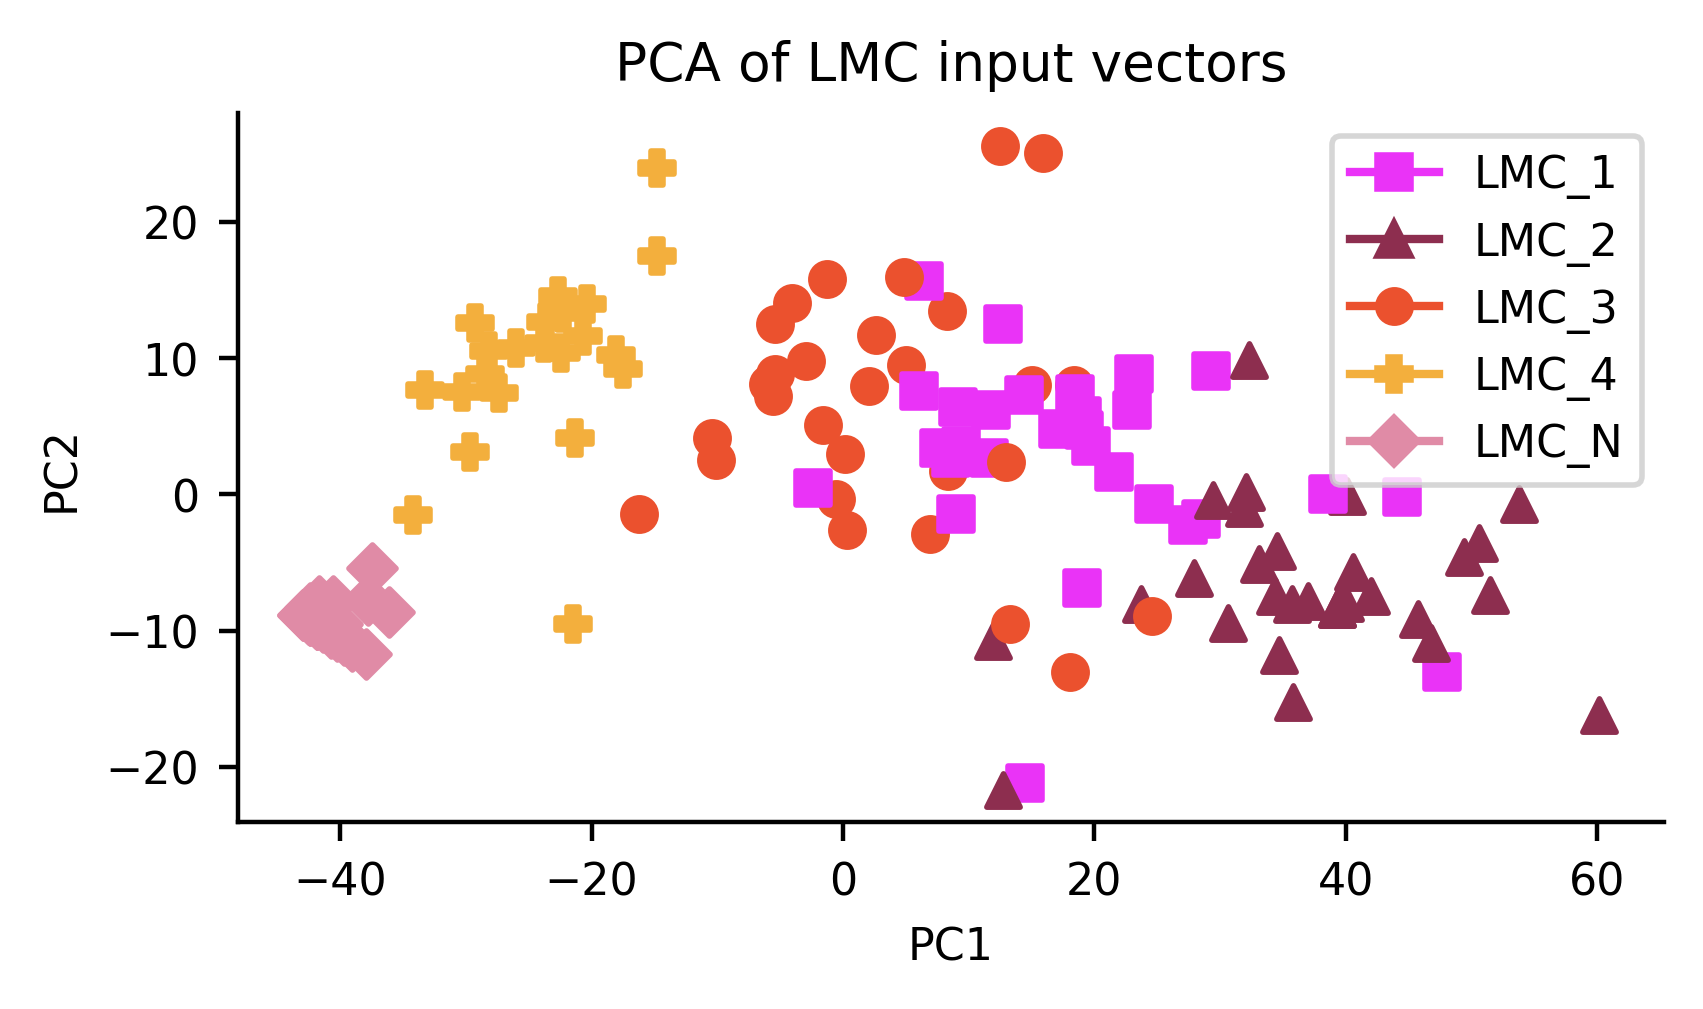

array([[ 5.22999532e-03,  8.19470073e-02,  0.00000000e+00,
         6.74792803e-05,  2.86957502e-02,  5.69339869e-01,
         6.15632657e-01,  5.37849309e-01,  0.00000000e+00,
         7.38055568e-04,  7.68275621e-05,  0.00000000e+00],
       [ 7.68545986e-03,  7.72335713e-01, -1.11022302e-16,
         2.62468771e-04,  7.05117231e-02, -3.35261774e-01,
         4.52714030e-01, -2.84801699e-01,  0.00000000e+00,
        -1.99367297e-03,  2.75852693e-04,  0.00000000e+00]])

In [13]:
# PCA all LMCs by their INPUT VECTORS
pca = PCA(n_components=2)
lmc_ins = data.loc[[i for i, t in enumerate(data['type']) if t in lmcs], 
                   ('om', 'type', *subtypes)].drop('UNKNOWN', axis=1).reset_index()

X = lmc_ins.iloc[:, 3:]
display(X.columns)
X_r = pca.fit(X).transform(X)

fig = plt.figure(figsize=[4.6, 2.3])
ax = fig.gca()
ax.set_title("PCA of LMC input vectors") 
             #f"explained variance ratio (first two PCs): {pca.explained_variance_ratio_}")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

sts = []
for i, row in lmc_ins.iterrows():
    ax.scatter(X_r[i, 0], X_r[i, 1], color=c[row['type']], label=row['type'], marker=m[row['type']])
    sts.append(row['type'])
legend_elements = []

for s in sorted(np.unique(sts)):
    legend_elements.append(Line2D([0], [0], marker=m[s], color=c[s], label=s))
ax.legend(handles=legend_elements)
plt.show()

display(pca.components_)

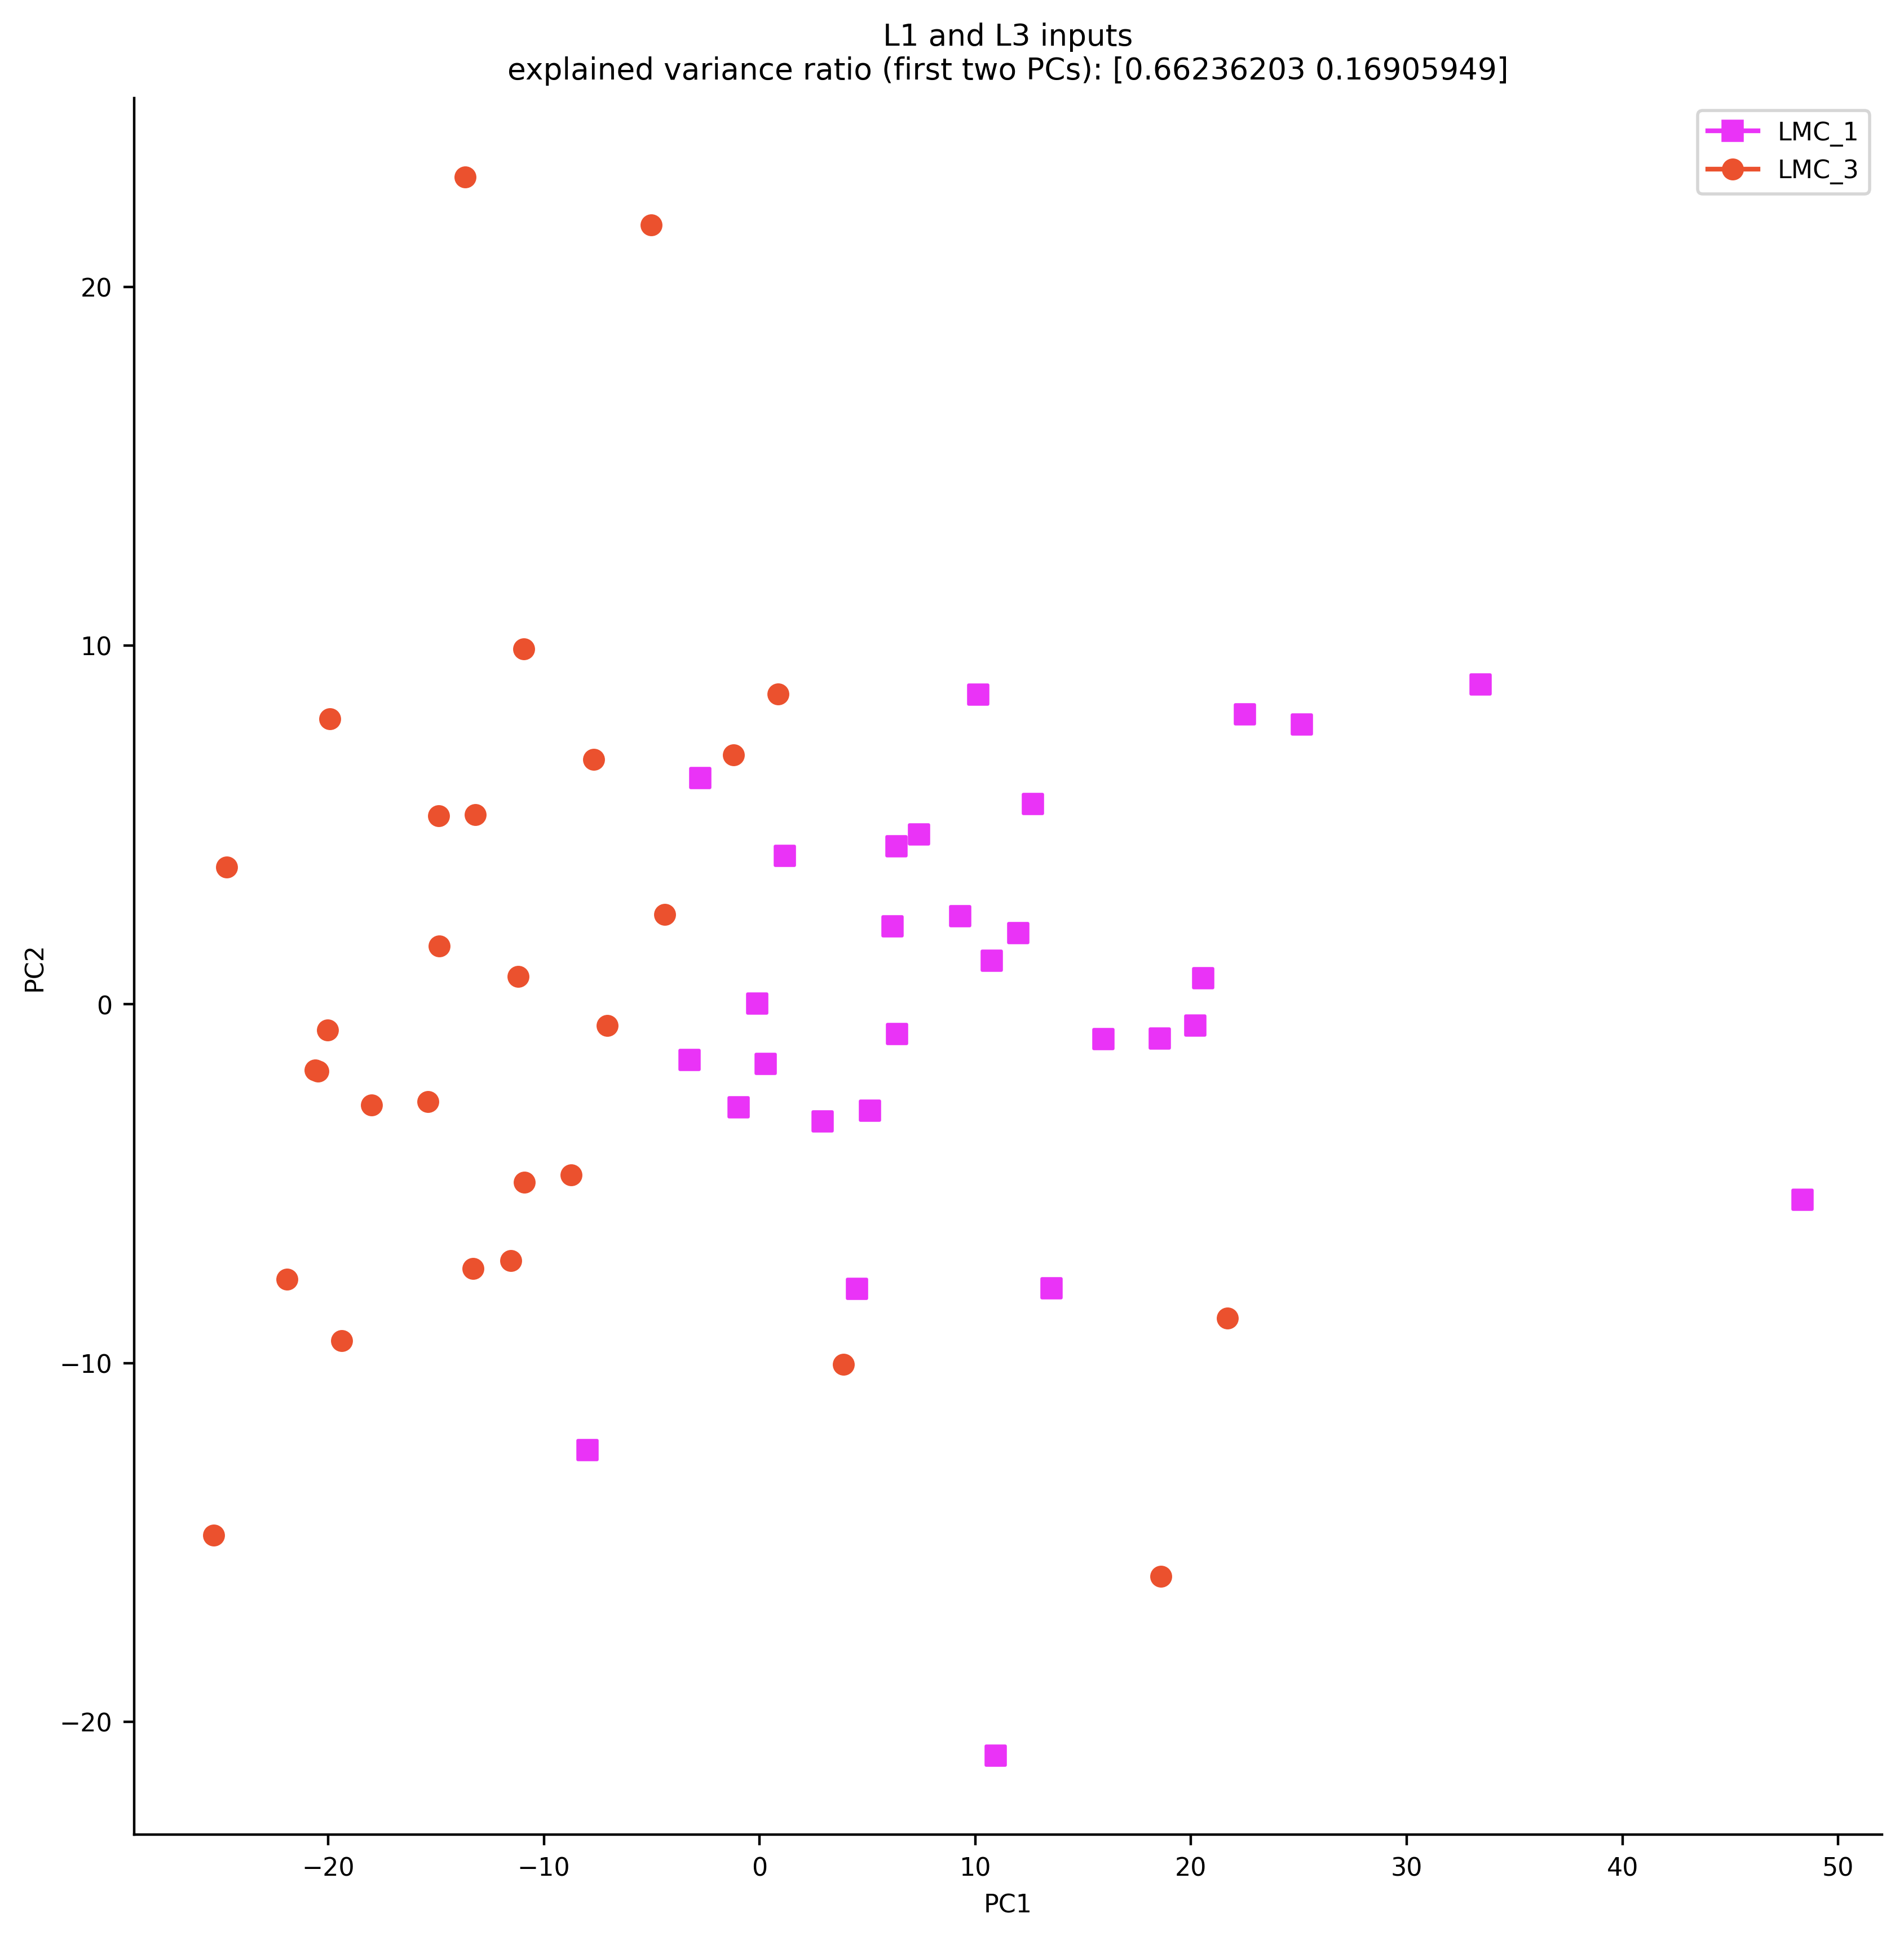

array([[-4.93412120e-03,  2.14948277e-01,  1.11022302e-16,
        -6.22849969e-04,  1.51030064e-02,  7.36891096e-01,
         2.04618987e-02,  6.40402093e-01, -0.00000000e+00,
         1.54455134e-03,  1.92601916e-05, -0.00000000e+00],
       [ 3.84423503e-02,  5.37744697e-01,  8.32667268e-17,
         7.95305980e-04,  7.79974299e-02, -1.65036310e-01,
         8.21986640e-01, -1.83823047e-02, -0.00000000e+00,
        -5.60832067e-03, -4.61035414e-04, -0.00000000e+00]])

In [29]:
# PCA L1 and L3 by their INPUT VECTORS
pca = PCA(n_components=2)
lmc_ins = data.loc[[i for i, t in enumerate(data['type']) if t in ('LMC_1', 'LMC_3')], 
                   ('om', 'type', *subtypes)].drop('UNKNOWN', axis=1).reset_index()

X = lmc_ins.iloc[:, 3:]
X_r = pca.fit(X).transform(X)

fig = plt.figure(figsize=[10, 10])
ax = fig.gca()
ax.set_title("L1 and L3 inputs\n" + 
             f"explained variance ratio (first two PCs): {pca.explained_variance_ratio_}")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
sts = []
for i, row in lmc_ins.iterrows():
    ax.scatter(X_r[i, 0], X_r[i, 1], color=c[row['type']], label=row['type'], marker=m[row['type']])
    sts.append(row['type'])
legend_elements = []
for s in sorted(np.unique(sts)):
    legend_elements.append(Line2D([0], [0], marker=m[s], color=c[s], label=s))
ax.legend(handles=legend_elements)
plt.show()

display(pca.components_)

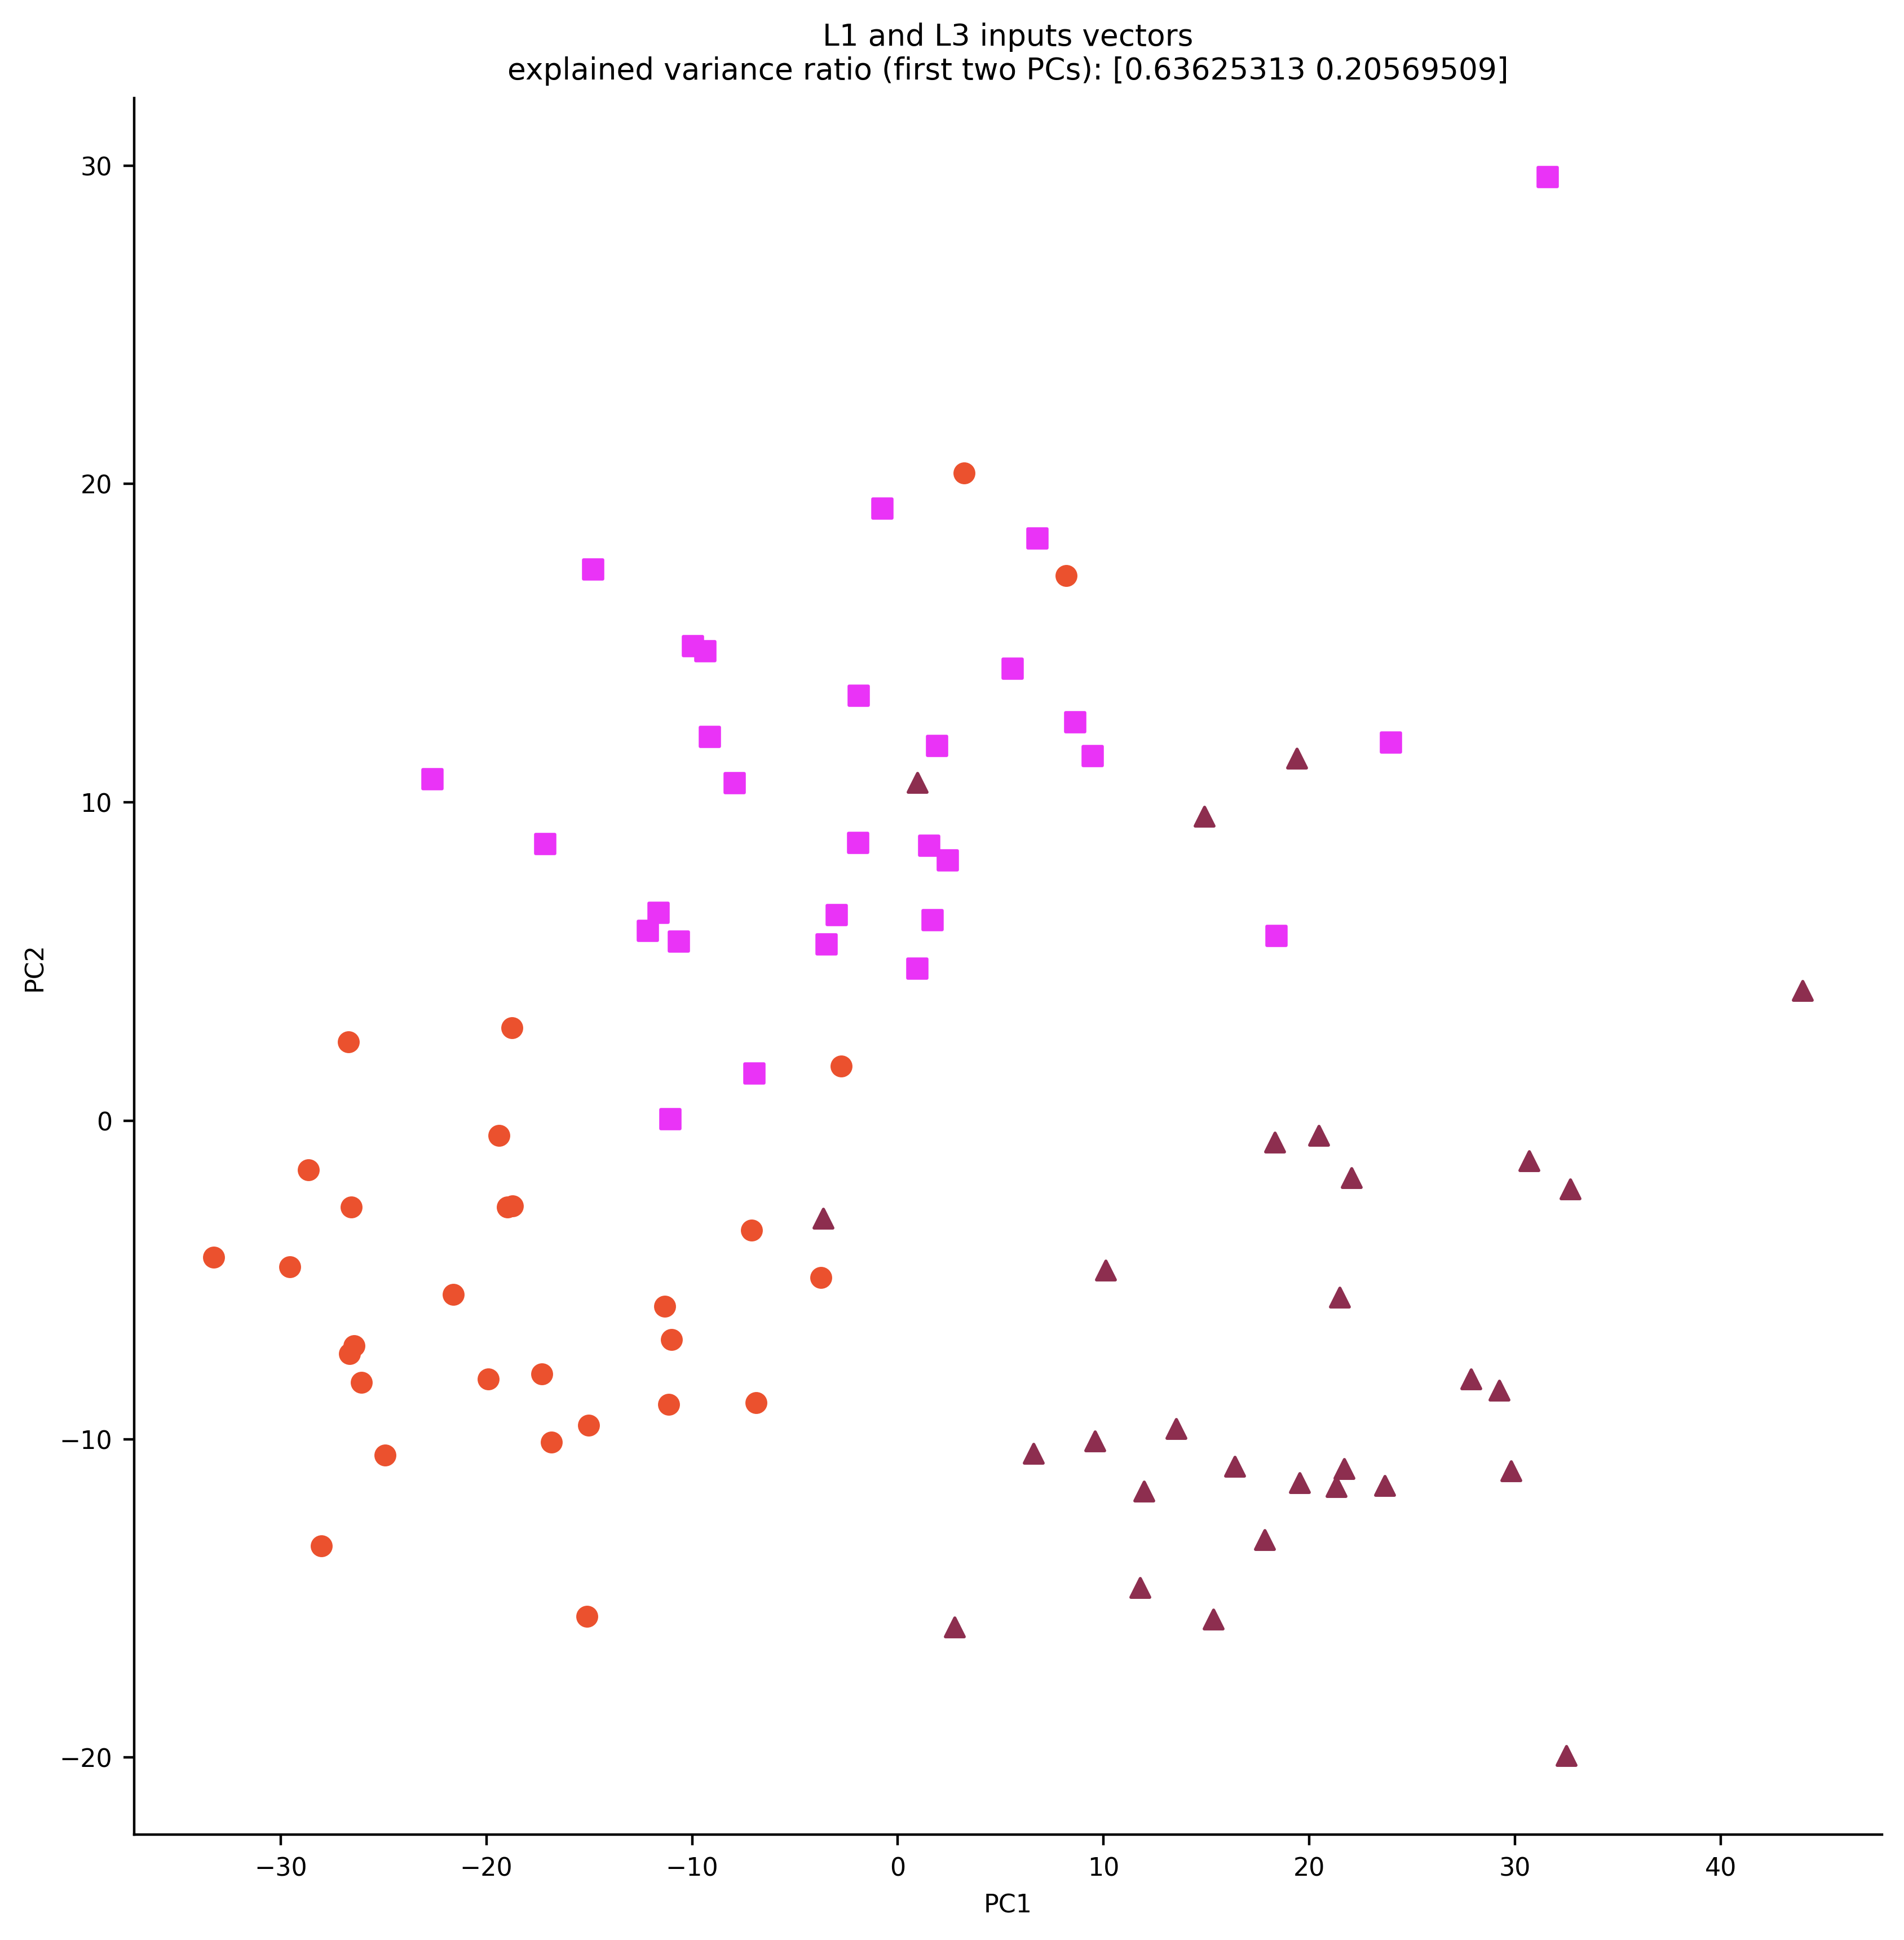

{'copy': True,
 'iterated_power': 'auto',
 'n_components': 2,
 'random_state': None,
 'svd_solver': 'auto',
 'tol': 0.0,
 'whiten': False}

In [30]:
# PCA L1 and L3 by their INPUT VECTORS
pca = PCA(n_components=2)
lmc_ins = data.loc[[i for i, t in enumerate(data['type']) if t in ('LMC_1', 'LMC_2', 'LMC_3')], 
                   ('om', 'type', *subtypes)].drop('UNKNOWN', axis=1).reset_index()

X = lmc_ins.iloc[:, 3:]
X_r = pca.fit(X).transform(X)

fig = plt.figure(figsize=[10, 10])
ax = fig.gca()
ax.set_title("L1 and L3 inputs vectors\n" + 
             f"explained variance ratio (first two PCs): {pca.explained_variance_ratio_}")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
for i, row in lmc_ins.iterrows():
    ax.scatter(X_r[i, 0], X_r[i, 1], color=c[row['type']], label=row['type'], marker=m[row['type']])

plt.show()

display(pca.get_params())

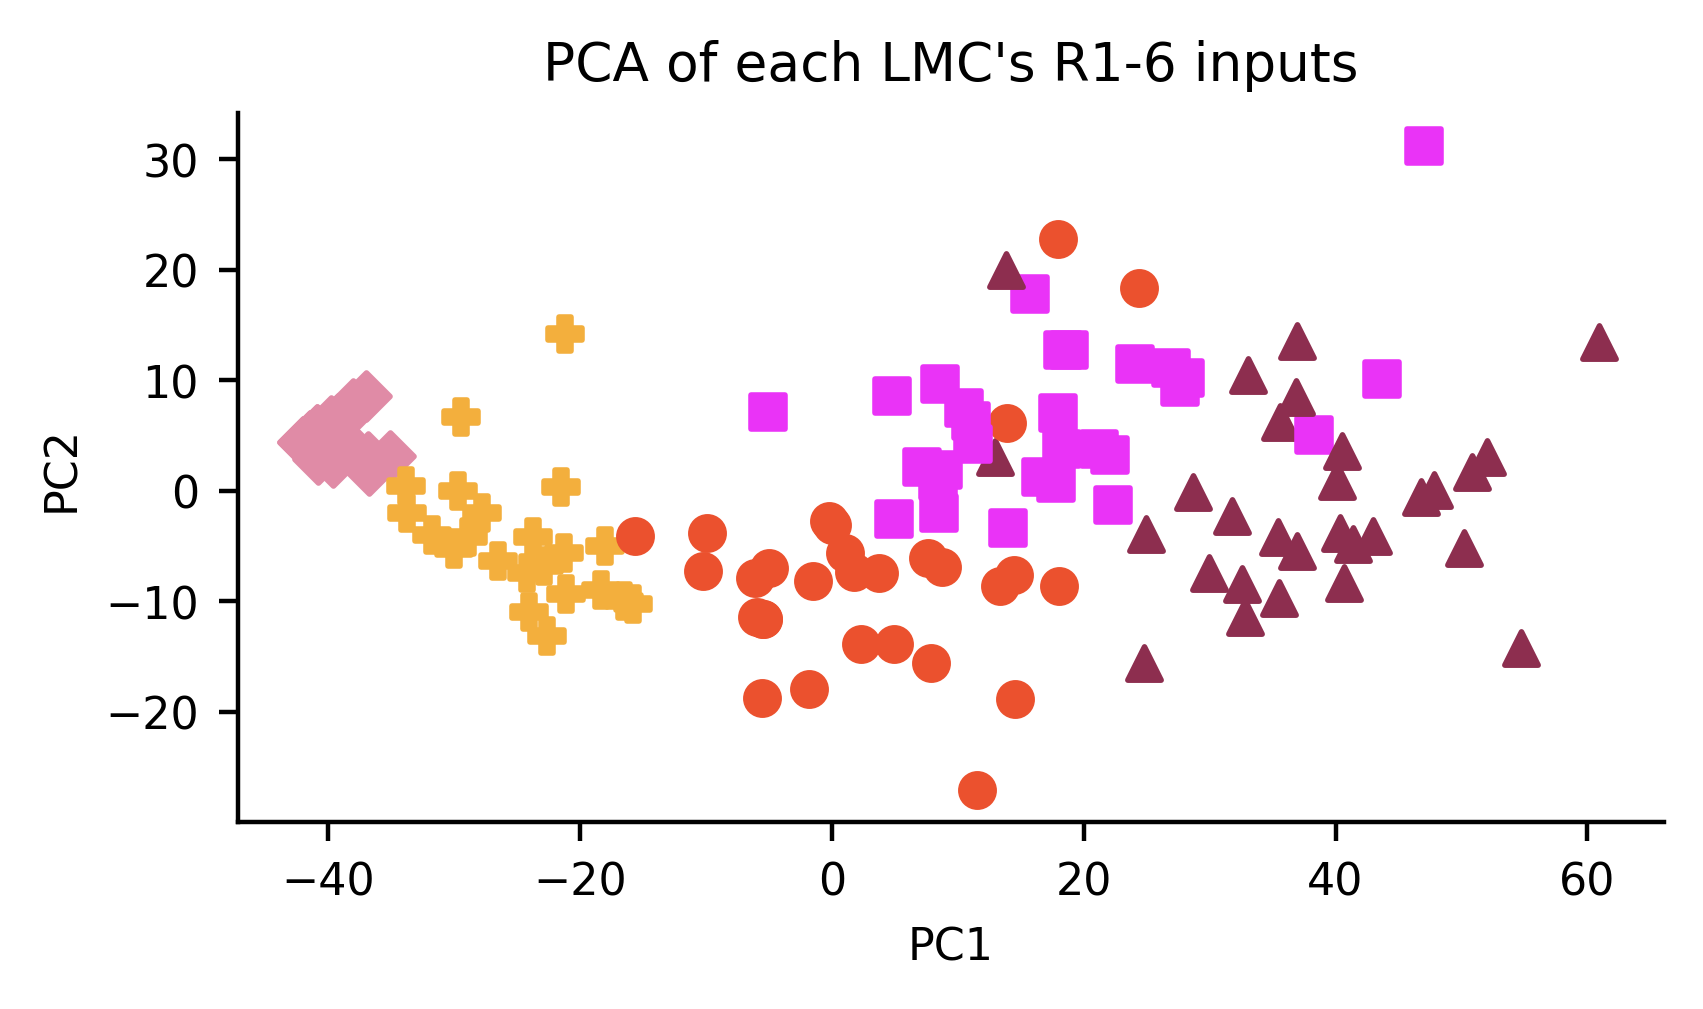

(138, 2)

In [40]:
# PCA all LMCs by their SHORT PHOTORECEPTOR INPUT VECTORS
pca = PCA(n_components=2)
lmc_ins = data.loc[[i for i, t in enumerate(data['type']) if t in lmcs], 
                   ('om', 'type', *subtypes)].drop('UNKNOWN', axis=1).reset_index()

X = lmc_ins.loc[:, ('R1R4', 'R2R5', 'R3R6')]
X_r = pca.fit(X).transform(X)

fig = plt.figure(figsize=[4.6, 2.3])
ax = fig.gca()
ax.set_title("PCA of each LMC's R1-6 inputs")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
             #f"explained variance ratio (first two PCs): {pca.explained_variance_ratio_}")
for i, row in lmc_ins.iterrows():
    ax.scatter(X_r[i, 0], X_r[i, 1], color=c[row['type']], label=row['type'], marker=m[row['type']])

plt.show()

display(X_r.shape)

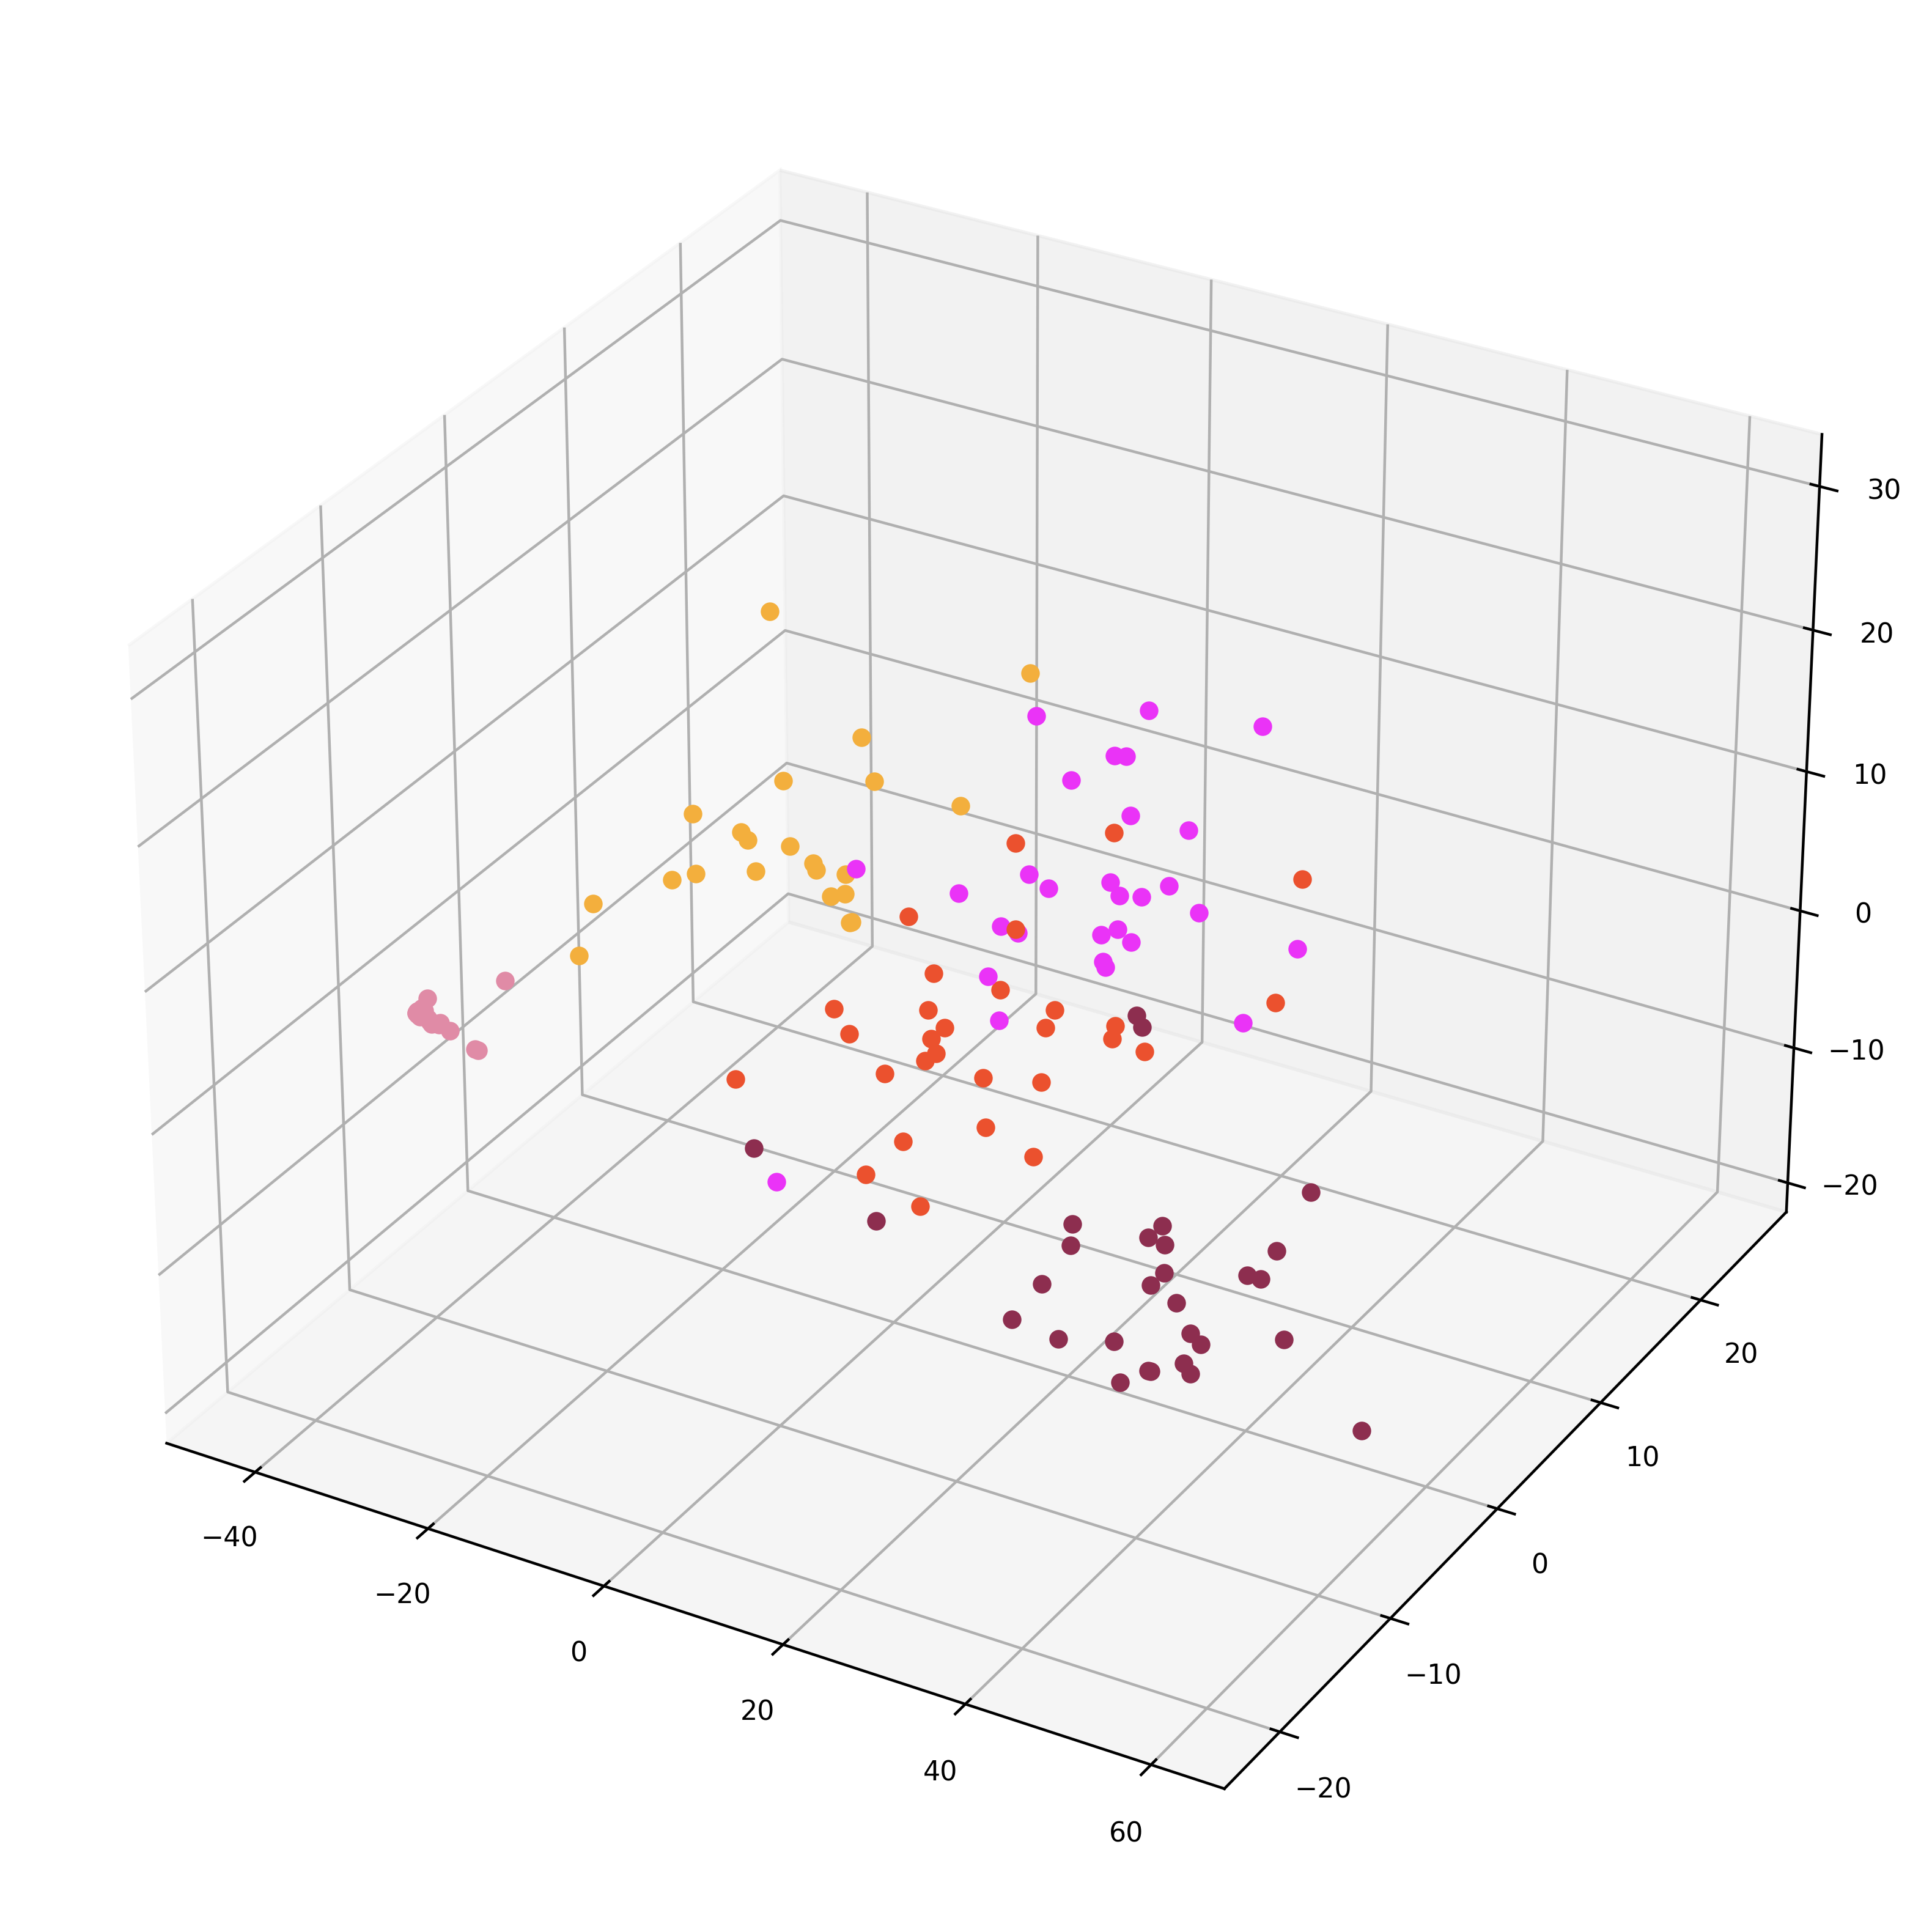

In [32]:
# PCA all LMCs by their INPUT VECTORS
pca = PCA(n_components=3)

X = lmc_ins.iloc[:, 3:]
X_r = pca.fit(X).transform(X)

fig = plt.figure(figsize=[10, 10])
ax = fig.gca(projection='3d')
for i, row in lmc_ins.iterrows():
    ax.scatter(X_r[i, 0], X_r[i, 1], X_r[i, 2], color=c[row['type']], label=row['type'])
plt.show()
ax.legend()
#display(X_r)

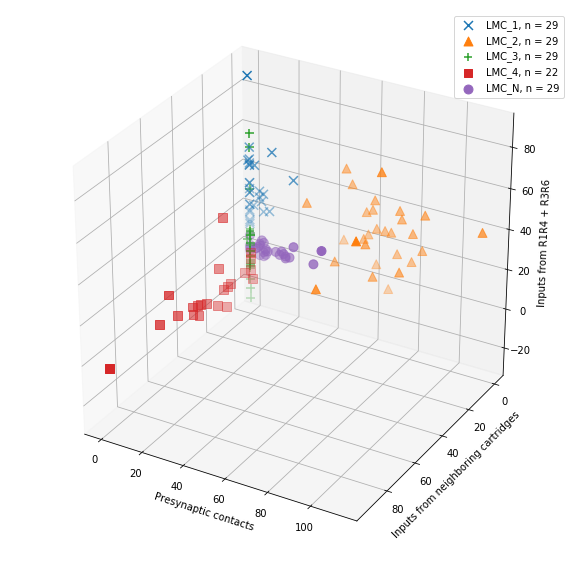

In [111]:
fig = plt.figure(figsize=[10, 10])
ax = fig.gca(projection='3d')
ax.set_xlabel('Presynaptic contacts')
ax.set_zlabel('Inputs from R1R4 + R3R6')
ax.set_ylabel('Inputs from neighboring cartridges')

for pre, rows in data.groupby('type'):
    if pre not in lmcs:
        continue
    else:
        #infrac = (rows['R1R4'] + rows['R3R6']) / (rows.filter(items=subtypes, axis=1).sum(axis=1))
        #infrac = (rows['R1R4'] + rows['R3R6']) / (rows['R1R4'] + rows['R2R5'] + rows['R3R6'])
        #infrac = rows['R1R4'] + rows['R3R6']
        infrac = rows['R1R4'] + rows['R3R6'] - rows['R2R5']
        ax.scatter(rows['output_count'], rows['inter_in'], infrac, 
                   label=f"{pre}, n = {len(rows)}", marker=m[pre], s=80, depthshade=True)
        #ax.scatter(rows['R1R4'] + rows['R3R6'], rows['inter_in'], rows['output_count'], label=pre)
ax.legend()

ax.invert_yaxis()
ax.view_init()
plt.show()

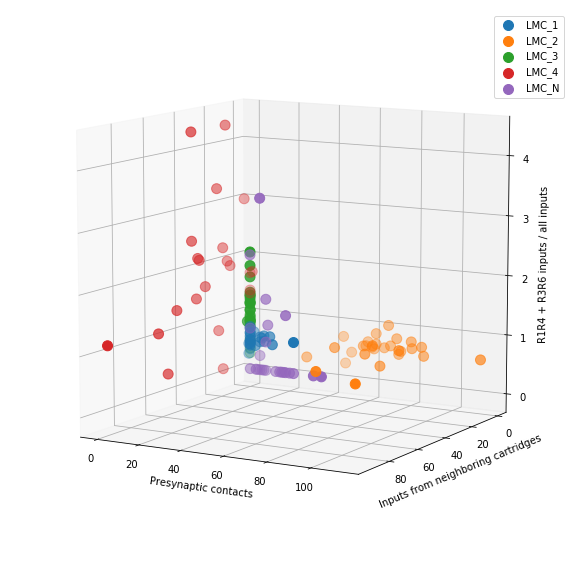

In [98]:
fig = plt.figure(figsize=[10, 10])
ax = fig.gca(projection='3d')
ax.set_xlabel('Presynaptic contacts')
ax.set_ylabel('Inputs from neighboring cartridges')
ax.set_zlabel('R1R4 + R3R6 inputs / all inputs')

for pre, rows in data.groupby('type'):
    if pre not in lmcs:
        continue
    else:
        #infrac = (rows['R1R4'] + rows['R3R6']) / (rows.filter(items=subtypes, axis=1).sum(axis=1))
        #infrac = (rows['R1R4'] + rows['R3R6']) / (rows['R1R4'] + rows['R2R5'] + rows['R3R6'])
        infrac = rows['R2R5'] / (rows['R1R4'] + rows['R3R6']) 
        #infrac = rows['R1R4'] + rows['R3R6']
        #s = rows.filter(items=subtypes, axis=1).sum(axis=1) + 50
        ax.scatter(rows['output_count'], rows['inter_in'], infrac, label=pre, s=100, depthshade=True)
        #ax.scatter(rows['R1R4'] + rows['R3R6'], rows['inter_in'], rows['output_count'], label=pre)
ax.legend()

ax.invert_yaxis()
ax.view_init(elev=10)
plt.show()

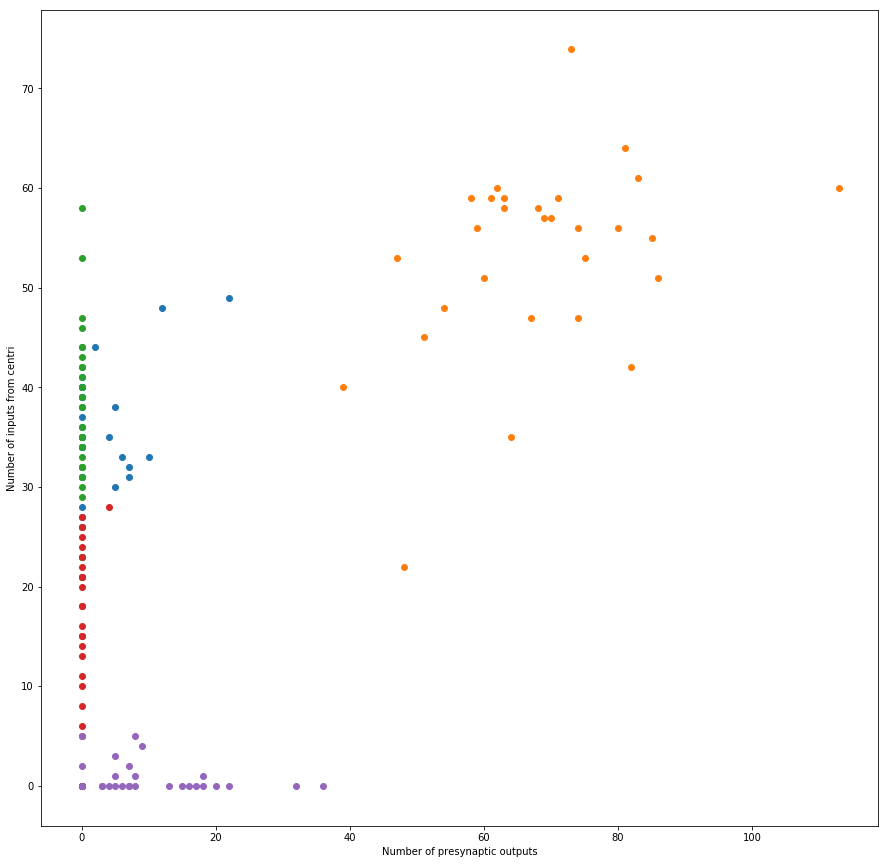

In [122]:
fig, ax = plt.subplots(1, figsize=[15, 15])
ax.set_xlabel('Number of presynaptic outputs')
ax.set_ylabel('Number of inputs from centri')

for pre, rows in data.groupby('type'):
    if pre not in lmcs:
        continue
    else:
        ax.scatter(x=rows['output_count'], y=rows['R2R5'])